# 1. Introduction

The Seattle Police Department (SPD) conducts Terry Stops as part of their law enforcement efforts to address public safety concerns. Terry Stops involve stopping, questioning, and sometimes frisking individuals based on reasonable suspicion of involvement in criminal activity. However, the effectiveness and fairness of these stops have been scrutinized, particularly regarding potential biases and the frequency of resulting arrests.


To address these concerns, this analysis aims to build a predictive model that can estimate the likelihood of an arrest occurring during a Terry Stop. By leveraging historical data, we can identify patterns and factors that are most indicative of an arrest outcome, which can inform policy decisions and improve the fairness and efficiency of law enforcement practices.

# 2. Problem Statement

The goal of this analysis is to develop a predictive model using historical Terry Stops data from the Seattle Police Department to estimate the likelihood of an arrest during these stops. The primary challenge lies in accurately predicting arrests in a dataset that exhibits significant class imbalance, with most stops not resulting in an arrest. Addressing this imbalance and ensuring the model's predictions are both accurate and fair are critical to the success of this project.

# 3. Objectives

**Major Objective:**

**a. Derive the most important features in predicting an arrest:**

Over and above getting insights into why officers make arrests, this is important to assess whether the future arrest trends are being influenced by changing dynamics.


**Minor Objectives**

**b.Develop a Predictive Model for Arrests During Terry Stops:**

Create a logistic regression model that accurately predicts whether a Terry Stop will result in an arrest, using features derived from the dataset.

**c. EDA and Feature Engineering:**

- Perform an exploratory data analysis (EDA) to identify the distribution, relationships, and potential issues with the variables, such as missing values, which could impact model performance.

- Implement and compare different encoding techniques (one-hot encoding for low cardinality features and target encoding for high cardinality features) to effectively incorporate categorical variables into the model without increasing dimensionality.

**d. Class Imbalance Management:**

Evaluate and apply resampling techniques like SMOTE to address the class imbalance in the dataset, ensuring that the model can reliably predict both outcomes (arrests and non-arrests) without bias toward the majority class.

# 4. Data Understanding

### Imports & Data Loading

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_curve, roc_auc_score



In [66]:
import pandas as pd

df = pd.read_csv('Terry_Stops_20240819.csv')
df.head()

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Reported Time,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat
0,1 - 17,-1,20150000002502,47107,Offense Report,None,6358,1970,M,White,...,23:52:00.0000000,-,-,-,WEST PCT 3RD W - MARY - PLATOON 1,N,N,-,-,-
1,36 - 45,32643034540,20220000318696,38698204851,Arrest,-,7560,1986,M,White,...,12:24:59.0000000,ORDER - CRITICAL VIOLATION OF DV COURT ORDER,--DV - ENFORCE COURT ORDER (ARREST MANDATED),"TELEPHONE OTHER, NOT 911",SOUTH PCT 1ST W - R/S RELIEF,Y,N,South,S,S1
2,18 - 25,-1,20180000003995,497654,Field Contact,None,7428,1963,M,Hispanic or Latino,...,16:18:00.0000000,-,-,-,WEST PCT OPS - CPT,N,N,-,-,-
3,46 - 55,-1,20150000299600,109376,Field Contact,None,6805,1973,M,White,...,15:53:00.0000000,SUSPICIOUS STOP - OFFICER INITIATED ONVIEW,--DISTURBANCE - OTHER,ONVIEW,WEST PCT 2ND W - DAVID - PLATOON 1,N,N,West,D,D3
4,26 - 35,-1,20160000438879,219794,Offense Report,None,5781,1963,M,Black or African American,...,15:51:00.0000000,THEFT (DOES NOT INCLUDE SHOPLIFT OR SVCS),--THEFT - SHOPLIFT,ONVIEW,SOUTHWEST PCT 2ND WATCH - F/W RELIEF,N,N,Southwest,W,W2


### Exploratory Data Analysis (EDA) & Feature Engineering

In [67]:
df.shape

(60962, 23)

In [68]:
df.describe()

,Subject ID,GO / SC Num,Terry Stop ID,Officer YOB
count,6.096200e+04,6.096200e+04,6.096200e+04,60962.000000
mean,7.246509e+09,2.018660e+13,1.213135e+10,1984.077474
std,1.265918e+10,8.575239e+10,1.749055e+10,9.472551
min,-8.000000e+00,-1.000000e+00,2.802000e+04,1900.000000
25%,-1.000000e+00,2.017000e+13,2.387742e+05,1979.000000
50%,-1.000000e+00,2.018000e+13,5.086870e+05,1986.000000
75%,7.752270e+09,2.021000e+13,1.953036e+10,1991.000000
max,5.845336e+10,2.024000e+13,5.845333e+10,2002.000000


Given the shape and description of our data, most of our features seem non-numeric 

Our data has 23 columns and 609562 rows

In [69]:
df.columns

Index(['Subject Age Group', 'Subject ID', 'GO / SC Num', 'Terry Stop ID',
       'Stop Resolution', 'Weapon Type', 'Officer ID', 'Officer YOB',
       'Officer Gender', 'Officer Race', 'Subject Perceived Race',
       'Subject Perceived Gender', 'Reported Date', 'Reported Time',
       'Initial Call Type', 'Final Call Type', 'Call Type', 'Officer Squad',
       'Arrest Flag', 'Frisk Flag', 'Precinct', 'Sector', 'Beat'],
      dtype='object')

These are the columns in our data and their descriptions based on a review of our data and information from our data source: (https://data.seattle.gov/Public-Safety/Terry-Stops/28ny-9ts8/about_data):

1. Subject Age Group - Subject Age Group (10 year increments) as reported by the officer (Text)

2. Subject ID - Key, generated daily, identifying unique subjects in the dataset using a character to character match of first name and last         name. "Null" values indicate an "anonymous" or "unidentified" subject. Subjects of a Terry Stop are not required to present identification. (Text)

3. GO / SC Num - General Offense or Street Check number, relating the Terry Stop to the parent report. This field may have a one to many relationship in the data. (Text)

4. Terry Stop ID - 	Key identifying unique Terry Stop reports. (Text)

5. Stop Resolution - Resolution of the stop as reported by the officer. (Text)

6. Weapon Type - Type of weapon, if any, identified during a search or frisk of the subject. Indicates "None" if no weapons was found. (Text)

7. Officer ID  - Key identifying unique officers in the dataset. (Text)

8. Officer YOB - Year of birth, as reported by the officer. (Text)

9. Officer Gender - Gender of the officer, as reported by the officer. (Text)

10. Officer Race - Race of the officer, as reported by the officer. (Text)

11. Subject Perceived Race - Perceived race of the subject, as reported by the officer. (Text)

12. Subject Perceived Gender - Perceived gender of the subject, as reported by the officer. (Text)

13. Reported Date - Date the report was filed in the Records Management System (RMS). Not necessarily the date the stop occurred but generally within 1 day. (Floating Timestamp)

14. Reported Time - Time the stop was reported in the Records Management System (RMS). Not the time the stop occurred but generally within 10 hours. (Text)

15. Initial Call Type - Initial classification of the call as assigned by 911. (Text)

16. Final Call Type - Final classification of the call as assigned by the primary officer closing the event. (Text)

17. Call Type - How the call was received by the communication center. (Text)

18. Officer Squad - Functional squad assignment (not budget) of the officer as reported by the Data Analytics Platform (DAP). (Text)

19. Arrest Flag - Indicator of whether a "physical arrest" was made, of the subject, during the Terry Stop. Does not necessarily reflect a report of an arrest in the Records Management System (RMS). (Text)

20. Frisk Flag - Indicator of whether a "frisk" was conducted, by the officer, of the subject, during the Terry Stop. (Text)

21. Precint - Precinct of the address associated with the underlying Computer Aided Dispatch (CAD) event. Not necessarily where the Terry Stop occurred. (Text)

22. Sector - Sector of the address associated with the underlying Computer Aided Dispatch (CAD) event. Not necessarily where the Terry Stop occurred. (Text)

23. Beat - Beat of the address associated with the underlying Computer Aided Dispatch (CAD) event. Not necessarily where the Terry Stop occurred. (Text)


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60962 entries, 0 to 60961
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Subject Age Group         60962 non-null  object
 1   Subject ID                60962 non-null  int64 
 2   GO / SC Num               60962 non-null  int64 
 3   Terry Stop ID             60962 non-null  int64 
 4   Stop Resolution           60962 non-null  object
 5   Weapon Type               60962 non-null  object
 6   Officer ID                60962 non-null  object
 7   Officer YOB               60962 non-null  int64 
 8   Officer Gender            60962 non-null  object
 9   Officer Race              60962 non-null  object
 10  Subject Perceived Race    60962 non-null  object
 11  Subject Perceived Gender  60962 non-null  object
 12  Reported Date             60962 non-null  object
 13  Reported Time             60962 non-null  object
 14  Initial Call Type     

We seem to have a mix of numerical and non-numerical data. However, the numeric data seems to be related to identifiers vs actual numerical data

In [71]:
df.isna().sum()

Subject Age Group             0
Subject ID                    0
GO / SC Num                   0
Terry Stop ID                 0
Stop Resolution               0
Weapon Type                   0
Officer ID                    0
Officer YOB                   0
Officer Gender                0
Officer Race                  0
Subject Perceived Race        0
Subject Perceived Gender      0
Reported Date                 0
Reported Time                 0
Initial Call Type             0
Final Call Type               0
Call Type                     0
Officer Squad               561
Arrest Flag                   0
Frisk Flag                    0
Precinct                      0
Sector                        0
Beat                          0
dtype: int64

We have missing data in the Officer Squad column. We will impute this column with a placeholder 'Unknown' Value

In [72]:
df_imputed = df.fillna('Unknown')
df_imputed.head()

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Reported Time,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat
0,1 - 17,-1,20150000002502,47107,Offense Report,None,6358,1970,M,White,...,23:52:00.0000000,-,-,-,WEST PCT 3RD W - MARY - PLATOON 1,N,N,-,-,-
1,36 - 45,32643034540,20220000318696,38698204851,Arrest,-,7560,1986,M,White,...,12:24:59.0000000,ORDER - CRITICAL VIOLATION OF DV COURT ORDER,--DV - ENFORCE COURT ORDER (ARREST MANDATED),"TELEPHONE OTHER, NOT 911",SOUTH PCT 1ST W - R/S RELIEF,Y,N,South,S,S1
2,18 - 25,-1,20180000003995,497654,Field Contact,None,7428,1963,M,Hispanic or Latino,...,16:18:00.0000000,-,-,-,WEST PCT OPS - CPT,N,N,-,-,-
3,46 - 55,-1,20150000299600,109376,Field Contact,None,6805,1973,M,White,...,15:53:00.0000000,SUSPICIOUS STOP - OFFICER INITIATED ONVIEW,--DISTURBANCE - OTHER,ONVIEW,WEST PCT 2ND W - DAVID - PLATOON 1,N,N,West,D,D3
4,26 - 35,-1,20160000438879,219794,Offense Report,None,5781,1963,M,Black or African American,...,15:51:00.0000000,THEFT (DOES NOT INCLUDE SHOPLIFT OR SVCS),--THEFT - SHOPLIFT,ONVIEW,SOUTHWEST PCT 2ND WATCH - F/W RELIEF,N,N,Southwest,W,W2


In [73]:
df_imputed.duplicated().sum()

0

Our data does not have any duplicated rows

We also seem to have rows filled with '-'. We will treat these as missing values. 
First we need to convert these to NaN	

In [74]:
for column in df_imputed.columns:
    df_imputed[column] = df_imputed[column].replace('-', np.nan)

In [75]:
df_imputed.isna().sum()

Subject Age Group            2200
Subject ID                      0
GO / SC Num                     0
Terry Stop ID                   0
Stop Resolution                 0
Weapon Type                 24528
Officer ID                     24
Officer YOB                     0
Officer Gender                  0
Officer Race                    0
Subject Perceived Race       1816
Subject Perceived Gender      243
Reported Date                   0
Reported Time                   0
Initial Call Type           13473
Final Call Type             13473
Call Type                   13473
Officer Squad                   0
Arrest Flag                     0
Frisk Flag                    478
Precinct                    10617
Sector                      10768
Beat                        10762
dtype: int64

After deeper analysis of our data, we have several more columns with missing data.

We will handle these columns separately to preserve the quality of our data.

1. Subject Age Group  - we can impute this with mode to preserve the shape of our data.

2. Weapon Type - Given that a large portion is missing, it’s possible that in many cases, no weapon was found. Imputing missing values with "None" is most logical.

3. Officer ID - Since only 24 out of 60,962 entries are affected, we will drop these rows.

4. Subject Perceived Race - Replacing missing values with "Unknown" maintains the data structure without introducing bias.

5. Subject Perceived Gender - Replacing missing values with "Unknown" maintains the data structure without introducing bias.

6. Initial Call Type, Final Call Type, Call Type - Missing call types might suggest a lack of information or a specific condition (e.g., not applicable since no call was made and the incident just transpired). Imputing with "Unknown" preserves this possibility.

7. Frisk Flag - Since the missing values are minimal, using the most frequent value could be effective.

8. Precint, Sector, Beat - Geographic information might be missing due to unreported locations. We will fill with "Unknown" allows us to retain these rows.


In [76]:
columns_to_fill_with_mode = ['Subject Age Group', 'Frisk Flag']
columns_to_fill_with_unkown = ['Subject Perceived Race', 'Subject Perceived Gender', 'Initial Call Type'
, 'Final Call Type', 'Call Type', 'Precinct', 'Sector', 'Beat']
columns_to_fill_with_none = ['Weapon Type']
columns_to_drop = ['Officer ID']

for column in columns_to_fill_with_mode:
    df_imputed[column] = df_imputed[column].fillna(df_imputed[column].mode()[0])

for column in columns_to_fill_with_unkown:
    df_imputed[column] = df_imputed[column].fillna('Unknown')

for column in columns_to_fill_with_none:
    df_imputed[column] = df_imputed[column].fillna('None')

for column in columns_to_drop:
    df_imputed.dropna(inplace=True)

In [77]:
df_imputed.isna().sum()

Subject Age Group           0
Subject ID                  0
GO / SC Num                 0
Terry Stop ID               0
Stop Resolution             0
Weapon Type                 0
Officer ID                  0
Officer YOB                 0
Officer Gender              0
Officer Race                0
Subject Perceived Race      0
Subject Perceived Gender    0
Reported Date               0
Reported Time               0
Initial Call Type           0
Final Call Type             0
Call Type                   0
Officer Squad               0
Arrest Flag                 0
Frisk Flag                  0
Precinct                    0
Sector                      0
Beat                        0
dtype: int64

Our dataset no longer contains missing values.

We can use Officer YOB - Officer Year of Birth to extract and Age and put it this age into bins similar to our Subject Age Group by subtracting their year of birth from the year of the stop. 

In [78]:
bins = df_imputed['Subject Age Group'].unique()
bins

array(['1 - 17', '36 - 45', '18 - 25', '46 - 55', '26 - 35',
       '56 and Above'], dtype=object)

In [79]:

# Calculate Officer Age and add this to a new column
report_year = df_imputed['Reported Date'].str[:4].astype(int)
df_imputed['Officer Age'] = report_year - df_imputed['Officer YOB']
df_imputed.head()


,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat,Officer Age
0,1 - 17,-1,20150000002502,47107,Offense Report,None,6358,1970,M,White,...,Unknown,Unknown,Unknown,WEST PCT 3RD W - MARY - PLATOON 1,N,N,Unknown,Unknown,Unknown,45
1,36 - 45,32643034540,20220000318696,38698204851,Arrest,None,7560,1986,M,White,...,ORDER - CRITICAL VIOLATION OF DV COURT ORDER,--DV - ENFORCE COURT ORDER (ARREST MANDATED),"TELEPHONE OTHER, NOT 911",SOUTH PCT 1ST W - R/S RELIEF,Y,N,South,S,S1,36
2,18 - 25,-1,20180000003995,497654,Field Contact,None,7428,1963,M,Hispanic or Latino,...,Unknown,Unknown,Unknown,WEST PCT OPS - CPT,N,N,Unknown,Unknown,Unknown,55
3,46 - 55,-1,20150000299600,109376,Field Contact,None,6805,1973,M,White,...,SUSPICIOUS STOP - OFFICER INITIATED ONVIEW,--DISTURBANCE - OTHER,ONVIEW,WEST PCT 2ND W - DAVID - PLATOON 1,N,N,West,D,D3,42
4,26 - 35,-1,20160000438879,219794,Offense Report,None,5781,1963,M,Black or African American,...,THEFT (DOES NOT INCLUDE SHOPLIFT OR SVCS),--THEFT - SHOPLIFT,ONVIEW,SOUTHWEST PCT 2ND WATCH - F/W RELIEF,N,N,Southwest,W,W2,53


In [80]:
df_imputed['Officer Age'].describe()

count    60938.000000
mean        34.590666
std          8.793464
min         21.000000
25%         28.000000
50%         33.000000
75%         39.000000
max        121.000000
Name: Officer Age, dtype: float64

It's unlikely we have on duty officers above the age of 65 so we can drop rows with officers above this age

In [81]:
df_imputed = df_imputed[df_imputed['Officer Age'] <= 65]

df_imputed.head()


,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat,Officer Age
0,1 - 17,-1,20150000002502,47107,Offense Report,None,6358,1970,M,White,...,Unknown,Unknown,Unknown,WEST PCT 3RD W - MARY - PLATOON 1,N,N,Unknown,Unknown,Unknown,45
1,36 - 45,32643034540,20220000318696,38698204851,Arrest,None,7560,1986,M,White,...,ORDER - CRITICAL VIOLATION OF DV COURT ORDER,--DV - ENFORCE COURT ORDER (ARREST MANDATED),"TELEPHONE OTHER, NOT 911",SOUTH PCT 1ST W - R/S RELIEF,Y,N,South,S,S1,36
2,18 - 25,-1,20180000003995,497654,Field Contact,None,7428,1963,M,Hispanic or Latino,...,Unknown,Unknown,Unknown,WEST PCT OPS - CPT,N,N,Unknown,Unknown,Unknown,55
3,46 - 55,-1,20150000299600,109376,Field Contact,None,6805,1973,M,White,...,SUSPICIOUS STOP - OFFICER INITIATED ONVIEW,--DISTURBANCE - OTHER,ONVIEW,WEST PCT 2ND W - DAVID - PLATOON 1,N,N,West,D,D3,42
4,26 - 35,-1,20160000438879,219794,Offense Report,None,5781,1963,M,Black or African American,...,THEFT (DOES NOT INCLUDE SHOPLIFT OR SVCS),--THEFT - SHOPLIFT,ONVIEW,SOUTHWEST PCT 2ND WATCH - F/W RELIEF,N,N,Southwest,W,W2,53


In [82]:
df_imputed['Officer Age'].describe()

count    60835.000000
mean        34.469467
std          8.238621
min         21.000000
25%         28.000000
50%         33.000000
75%         39.000000
max         65.000000
Name: Officer Age, dtype: float64

The distribution of Officer Age now makes more sense

In [83]:
# Initialize bin_edges list and handle bins, setting the lower bound for the last bin to 56 (similar to Subject Age Group)
bin_edges = []
for bin in bins:
    if bin == '56 and Above':
        bin_edges.append(56) 
    else:
        lower_bound = int(bin.split(' - ')[0])
        bin_edges.append(lower_bound)
        

# Add the upper bound from the last bin 
max_age = df_imputed['Officer Age'].max()  
bin_edges.append(max_age)

# Remove duplicates and sort bin_edges
bin_edges = sorted(set(bin_edges))  

bin_edges

[1, 18, 26, 36, 46, 56, 65]

In [84]:
# We will use labels similar to those in Subject Age Group
labels = df_imputed['Subject Age Group'].unique().tolist()
labels

['1 - 17', '36 - 45', '18 - 25', '46 - 55', '26 - 35', '56 and Above']

In [85]:
print('length of bin_edges: ', len(bin_edges)-1)
print('length of labels: ', len(labels))

length of bin_dedges:  6
length of labels:  6


In [86]:
#compares the labels we extracted from the Subject Age Group column with the labels we created from the bins we created for Officer Age Group
labels = df_imputed['Subject Age Group'].unique().tolist()
if len(bin_edges) - 1 != len(labels):
    raise ValueError("The number of labels does not match the number of bins")

In [87]:
# Use pd.cut to create the bins for Officer Age
df_imputed['Officer Age Group'] = pd.cut(df_imputed['Officer Age'], bins=bin_edges, labels=labels, right=True)

print('Officer Age Group:', bins)
print('Subject Age Group:', labels)
df_imputed.head()



Officer Age Group: ['1 - 17' '36 - 45' '18 - 25' '46 - 55' '26 - 35' '56 and Above']
Subject Age Group: ['1 - 17', '36 - 45', '18 - 25', '46 - 55', '26 - 35', '56 and Above']


,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat,Officer Age,Officer Age Group
0,1 - 17,-1,20150000002502,47107,Offense Report,None,6358,1970,M,White,...,Unknown,Unknown,WEST PCT 3RD W - MARY - PLATOON 1,N,N,Unknown,Unknown,Unknown,45,46 - 55
1,36 - 45,32643034540,20220000318696,38698204851,Arrest,None,7560,1986,M,White,...,--DV - ENFORCE COURT ORDER (ARREST MANDATED),"TELEPHONE OTHER, NOT 911",SOUTH PCT 1ST W - R/S RELIEF,Y,N,South,S,S1,36,18 - 25
2,18 - 25,-1,20180000003995,497654,Field Contact,None,7428,1963,M,Hispanic or Latino,...,Unknown,Unknown,WEST PCT OPS - CPT,N,N,Unknown,Unknown,Unknown,55,26 - 35
3,46 - 55,-1,20150000299600,109376,Field Contact,None,6805,1973,M,White,...,--DISTURBANCE - OTHER,ONVIEW,WEST PCT 2ND W - DAVID - PLATOON 1,N,N,West,D,D3,42,46 - 55
4,26 - 35,-1,20160000438879,219794,Offense Report,None,5781,1963,M,Black or African American,...,--THEFT - SHOPLIFT,ONVIEW,SOUTHWEST PCT 2ND WATCH - F/W RELIEF,N,N,Southwest,W,W2,53,26 - 35


#### Columns to drop:

Next, we will drop some columns that do not provide useful information for our analysis. From a review of the column descriptions, we can ignore the following columns:

1. Subject ID: This is a unique identifier for each subject, not useful for modeling.

2. GO / SC Num: Unique identifier for reports, irrelevant for prediction.

3. Terry Stop ID: Another unique identifier.

4. Officer ID: Identifies each officer; may introduce bias and is not necessary.

5. Reported Date & Reported Time: Since they represent when the report was filed, not when the stop occurred, they may not be useful.

In [88]:
#change the datatype so Officer Age Group and Subject Age Group to ordinal categorical values.
df_imputed['Officer Age Group'] = pd.Categorical(df_imputed['Officer Age Group'],
                                         categories=bins,
                                         ordered=True)
df_imputed['Subject Age Group'] = pd.Categorical(df_imputed['Subject Age Group'],
                                         categories=labels,
                                         ordered=True)

In [89]:
columns_to_drop = ['Subject ID', 'GO / SC Num', 'Terry Stop ID', 'Officer ID', 'Reported Date', 'Reported Time','Officer Age','Officer YOB']

df_preprocessed = df_imputed.drop(columns=columns_to_drop, axis =1)

df_preprocessed.head()

,Subject Age Group,Stop Resolution,Weapon Type,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat,Officer Age Group
0,1 - 17,Offense Report,None,M,White,Unknown,Female,Unknown,Unknown,Unknown,WEST PCT 3RD W - MARY - PLATOON 1,N,N,Unknown,Unknown,Unknown,46 - 55
1,36 - 45,Arrest,None,M,White,Unknown,Male,ORDER - CRITICAL VIOLATION OF DV COURT ORDER,--DV - ENFORCE COURT ORDER (ARREST MANDATED),"TELEPHONE OTHER, NOT 911",SOUTH PCT 1ST W - R/S RELIEF,Y,N,South,S,S1,18 - 25
2,18 - 25,Field Contact,None,M,Hispanic or Latino,White,Male,Unknown,Unknown,Unknown,WEST PCT OPS - CPT,N,N,Unknown,Unknown,Unknown,26 - 35
3,46 - 55,Field Contact,None,M,White,American Indian or Alaska Native,Female,SUSPICIOUS STOP - OFFICER INITIATED ONVIEW,--DISTURBANCE - OTHER,ONVIEW,WEST PCT 2ND W - DAVID - PLATOON 1,N,N,West,D,D3,46 - 55
4,26 - 35,Offense Report,None,M,Black or African American,White,Female,THEFT (DOES NOT INCLUDE SHOPLIFT OR SVCS),--THEFT - SHOPLIFT,ONVIEW,SOUTHWEST PCT 2ND WATCH - F/W RELIEF,N,N,Southwest,W,W2,26 - 35


We have dropped 6 columns 'Subject ID', 'Officer YOB', 'GO / SC Num', 'Terry Stop ID', 'Officer ID', 'Reported Date',and 'Reported Time' from our original dataset and added one new column - Officer Age Group

Let us look at what our dataset looks like now

In [90]:
df_preprocessed.shape

(60835, 17)

In [91]:
df_preprocessed.duplicated().sum()

5967

Let's drop our duplicated rows - these may be rows entered multiple times under different IDs that we dropped

In [92]:
df_preprocessed.drop_duplicates(inplace = True)

In [93]:
print('Shape: ',df_preprocessed.shape)
print('Duplicates: ',df_preprocessed.duplicated().sum())

Shape:  (54868, 17)
Duplicates:  0


Our dataset now has 17 columns and 54,868 rows and no duplicates

In [94]:
df_preprocessed.columns

Index(['Subject Age Group', 'Stop Resolution', 'Weapon Type', 'Officer Gender',
       'Officer Race', 'Subject Perceived Race', 'Subject Perceived Gender',
       'Initial Call Type', 'Final Call Type', 'Call Type', 'Officer Squad',
       'Arrest Flag', 'Frisk Flag', 'Precinct', 'Sector', 'Beat',
       'Officer Age Group'],
      dtype='object')

In [96]:
df_preprocessed.describe()

,Subject Age Group,Stop Resolution,Weapon Type,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat,Officer Age Group
count,54868,54868,54868,54868,54868,54868,54868,54868,54868,54868,54868,54868,54868,54868,54868,54868,54868
unique,6,5,22,2,8,10,6,180,196,7,271,2,2,8,20,55,5
top,26 - 35,Field Contact,None,M,White,White,Male,Unknown,Unknown,911,TRAINING - FIELD TRAINING SQUAD,N,N,West,Unknown,Unknown,18 - 25
freq,20144,25055,51063,48582,38884,26448,43031,9769,9769,27519,5801,48364,40928,15917,7324,7318,29457


We are left with only categorical data from a review of the description. We will continu

#### Types of Variables:

Next we will look at the types of variables in our dataset. 

We have three columns with binary data - officer gender, arrest flag and frisk flag. We will convert these data to booleans

In [97]:
binary_columns = ['Arrest Flag', 'Frisk Flag', 'Officer Gender']

for column in binary_columns:
    df_preprocessed[column] = df_preprocessed[column] == 'Y' if column in ['Arrest Flag', 'Frisk Flag'] else df_preprocessed[column] == 'M'

df_preprocessed[binary_columns].head()

,Arrest Flag,Frisk Flag,Officer Gender
0,False,False,True
1,True,False,True
2,False,False,True
3,False,False,True
4,False,False,True


The goal of our analysis is to predict whether an arrest was made during a Terry Stop. Therefore , our target will be "Arrest Flag".

In [98]:
X = df_preprocessed.drop('Arrest Flag', axis = 1)
y = df_preprocessed['Arrest Flag']

In [99]:
# Identify categorical and numerical features
categorical = [var for var in X.columns if X[var].dtype in ['O', 'category', 'bool']]
numerical = [var for var in X.columns if X[var].dtype not in ['O', 'category','bool']]

print('Summary of Features\n')
print('There are {} numerical variables\n'.format(len(numerical)))
print('The numerical variables are :', numerical)

print('There are {} categorical variables\n'.format(len(categorical)))
print('The categorical variables are :', categorical)


Summary of Features

There are 0 numerical variables

The numerical variables are : []
There are 16 categorical variables

The categorical variables are : ['Subject Age Group', 'Stop Resolution', 'Weapon Type', 'Officer Gender', 'Officer Race', 'Subject Perceived Race', 'Subject Perceived Gender', 'Initial Call Type', 'Final Call Type', 'Call Type', 'Officer Squad', 'Frisk Flag', 'Precinct', 'Sector', 'Beat', 'Officer Age Group']


All our features are categorical variables. 

### Visualizing the distribution of our dataset

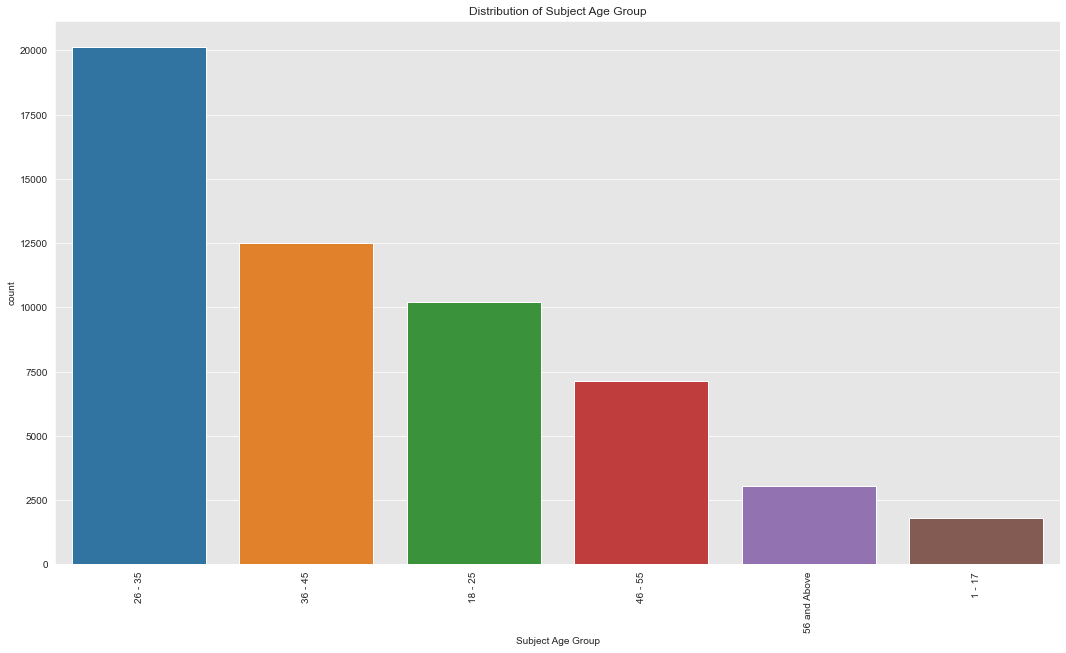

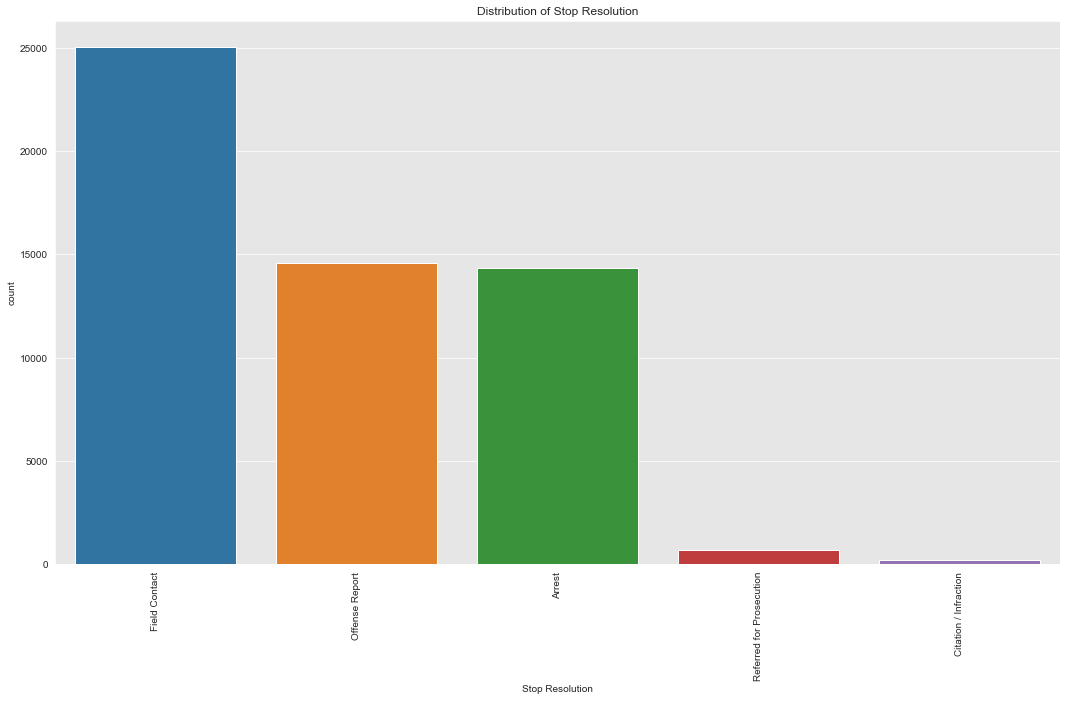

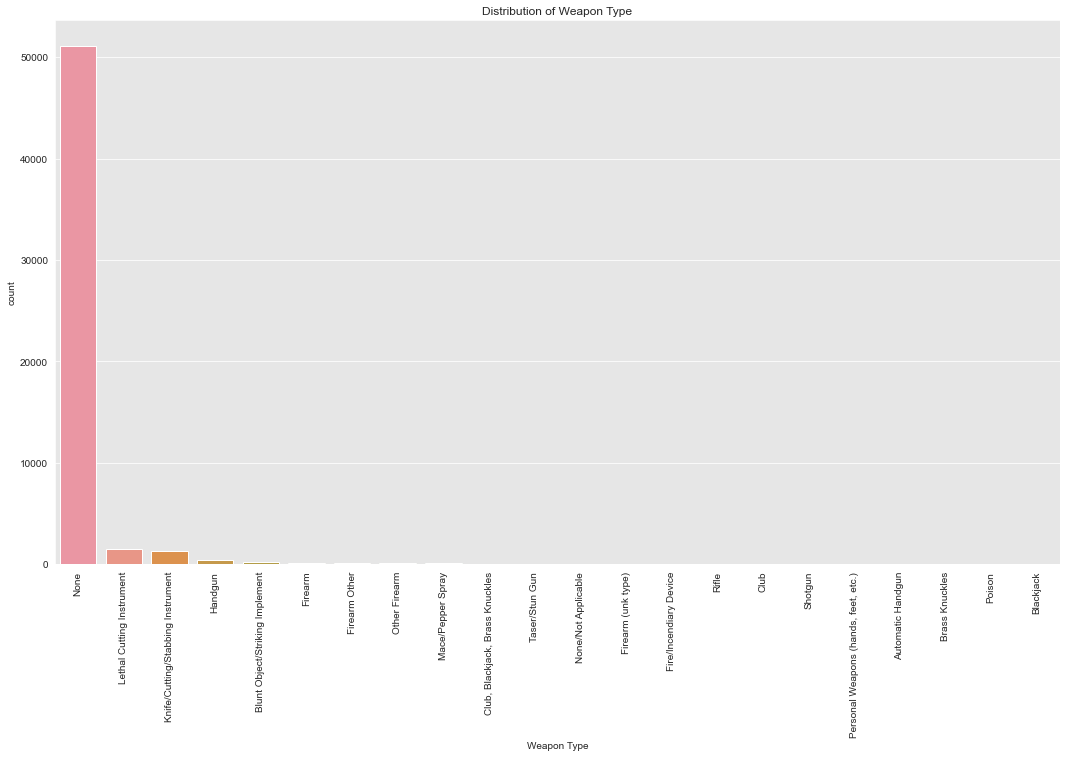

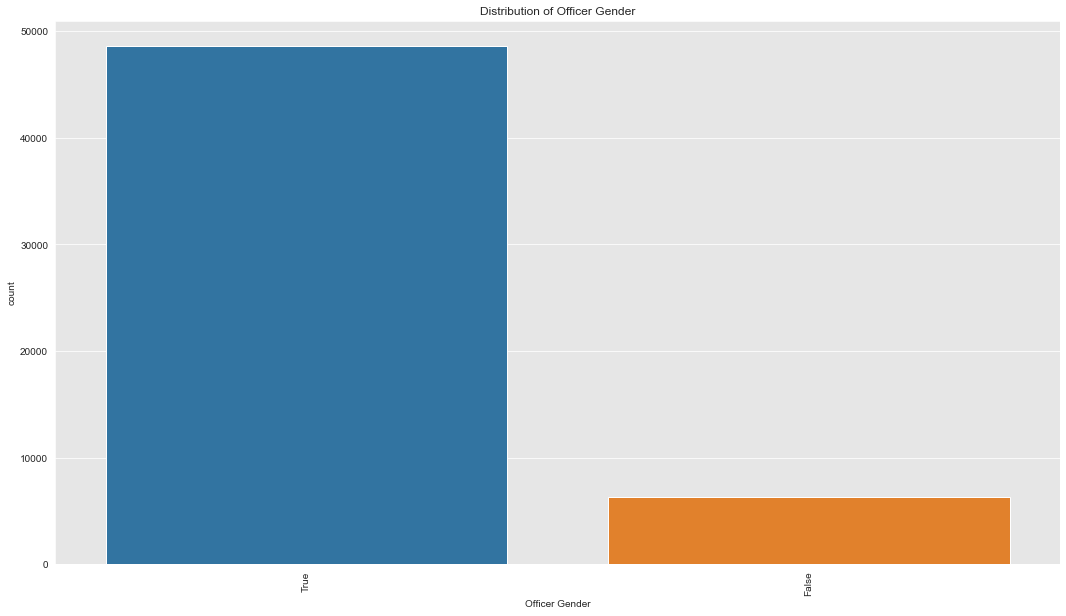

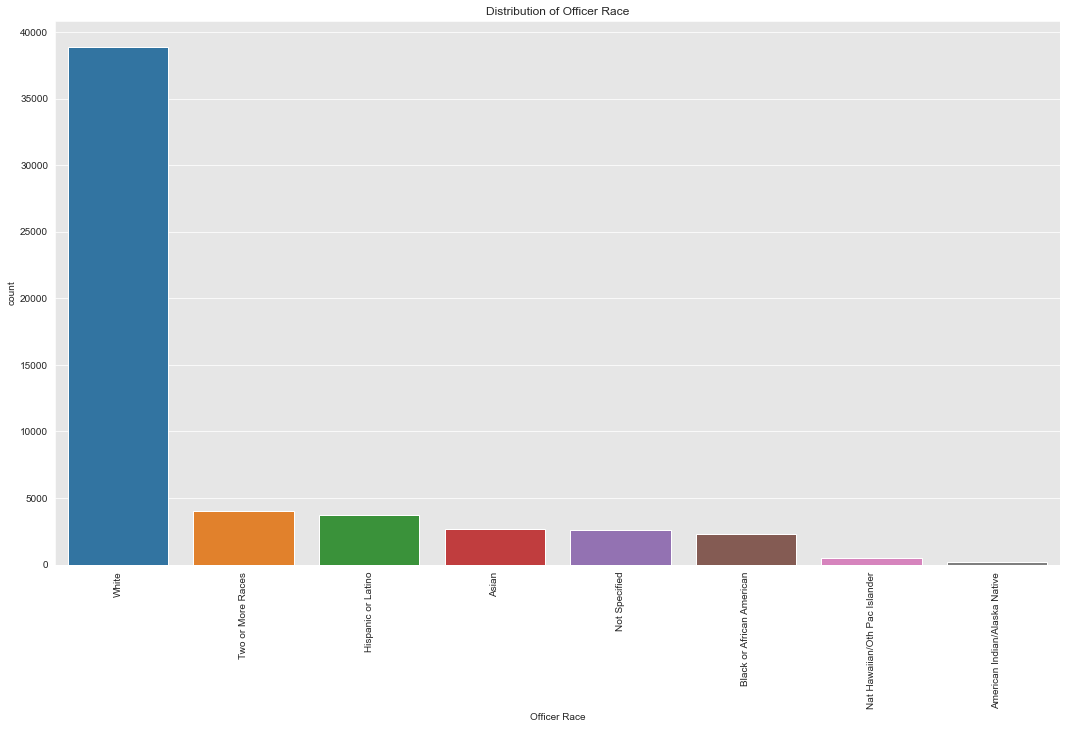

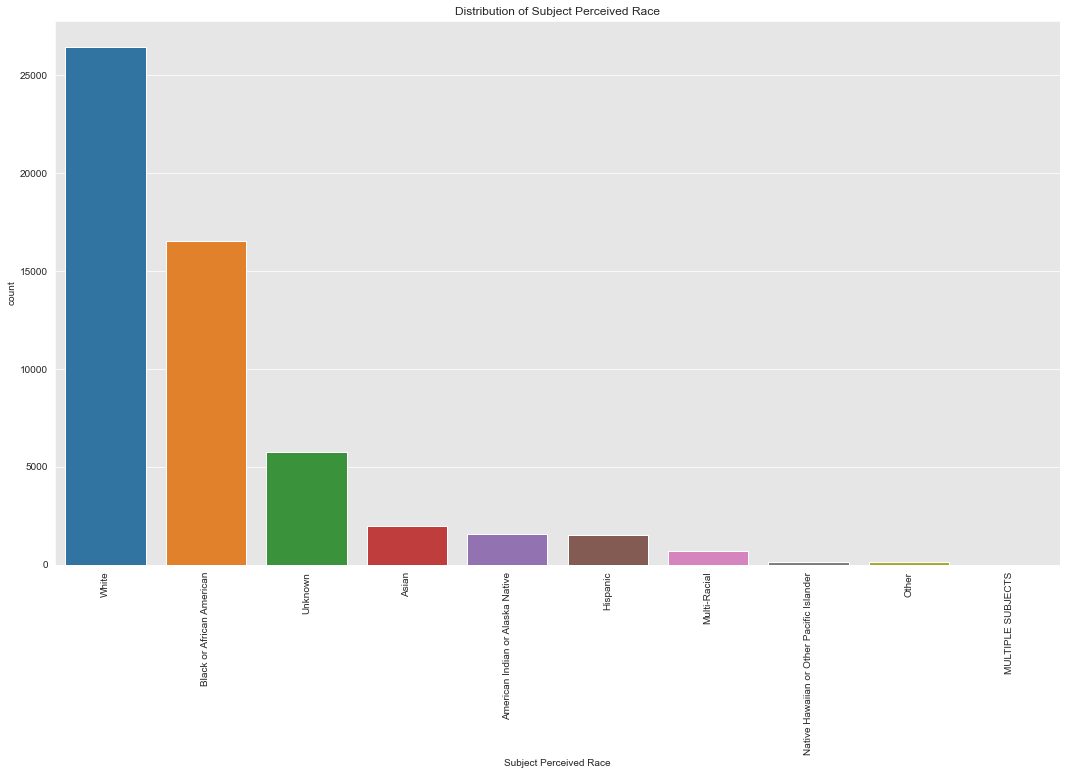

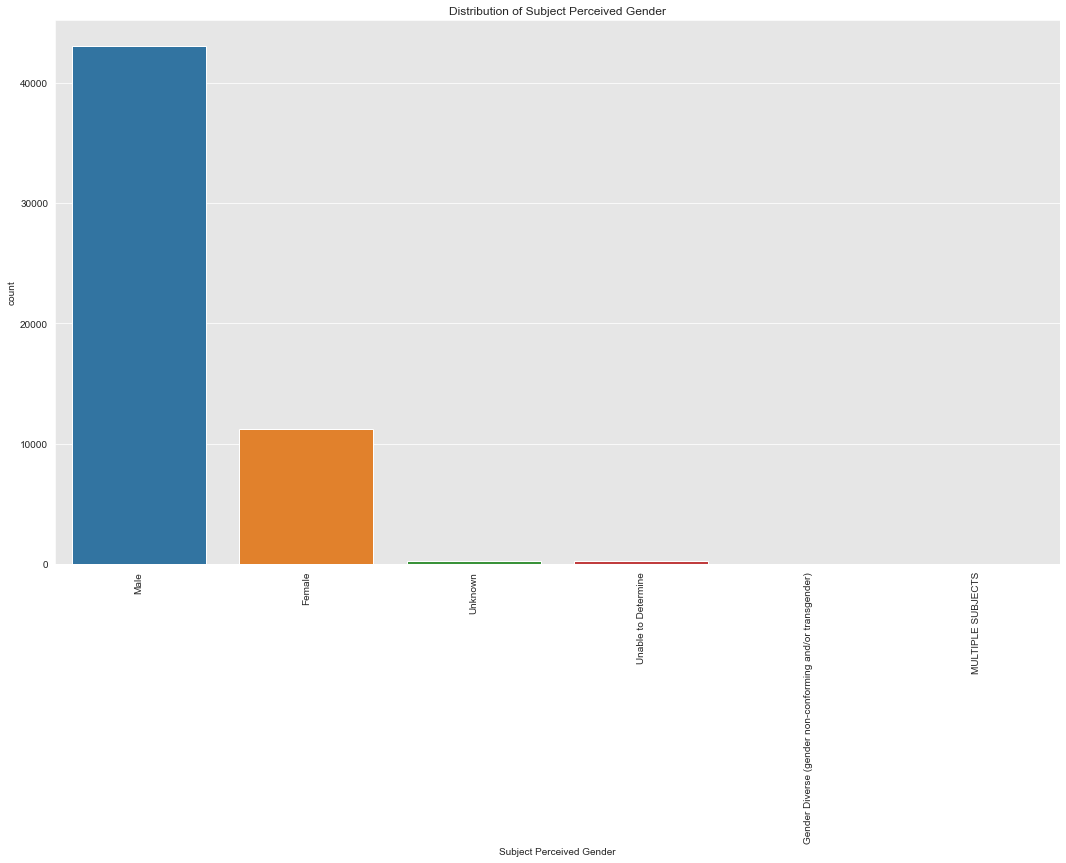

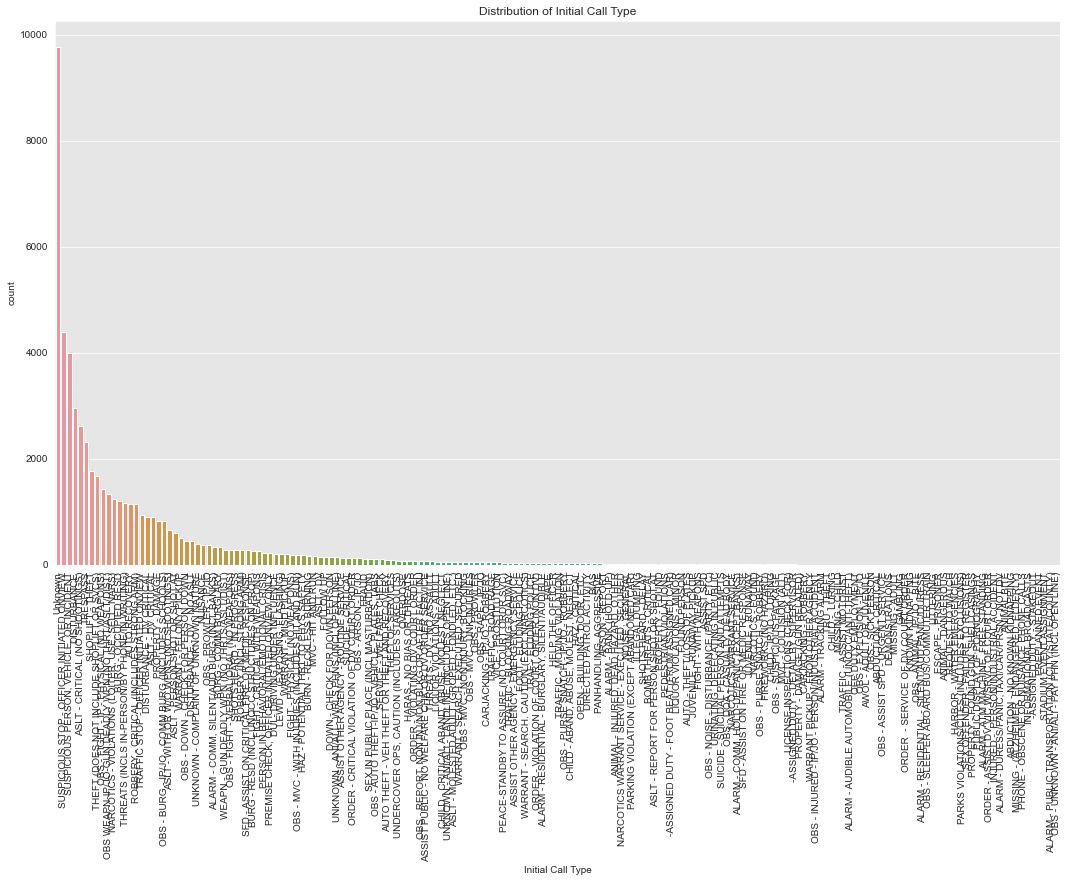

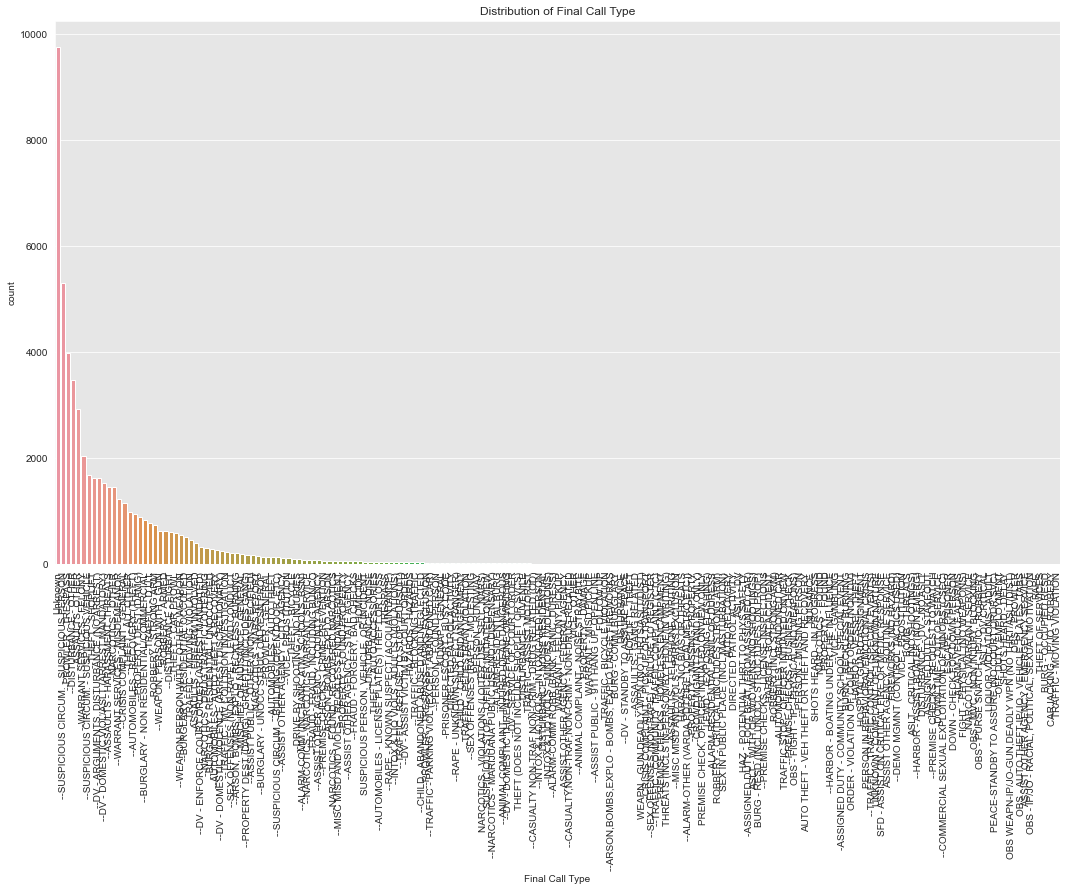

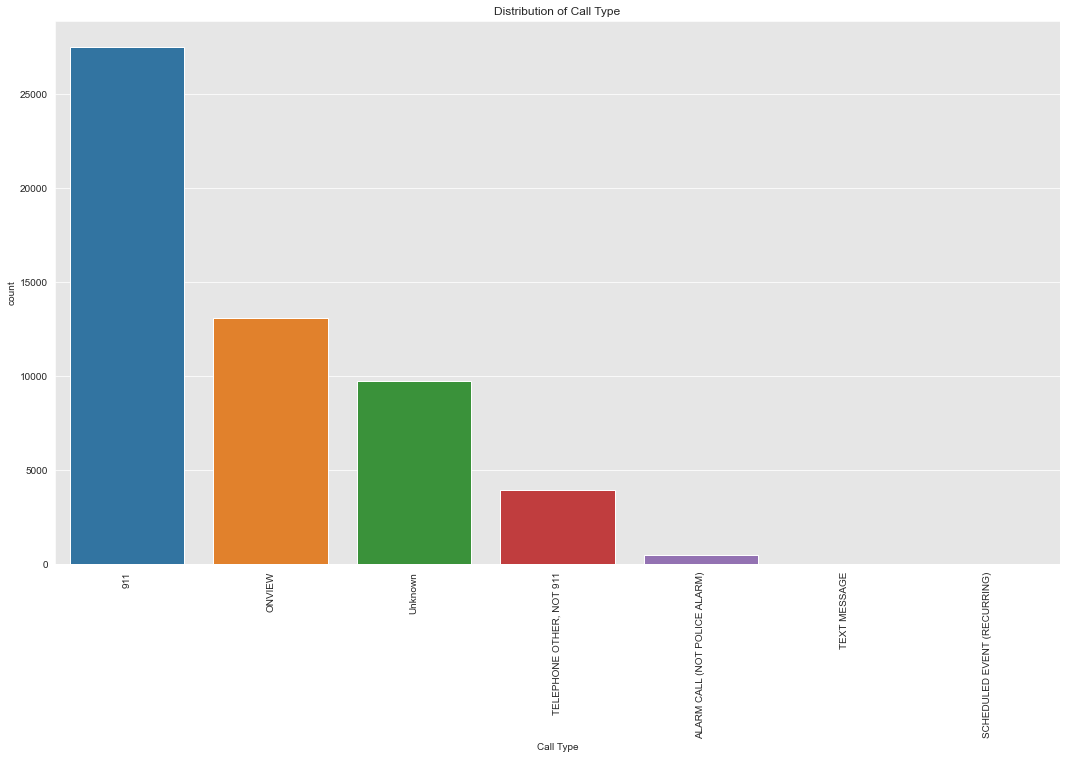

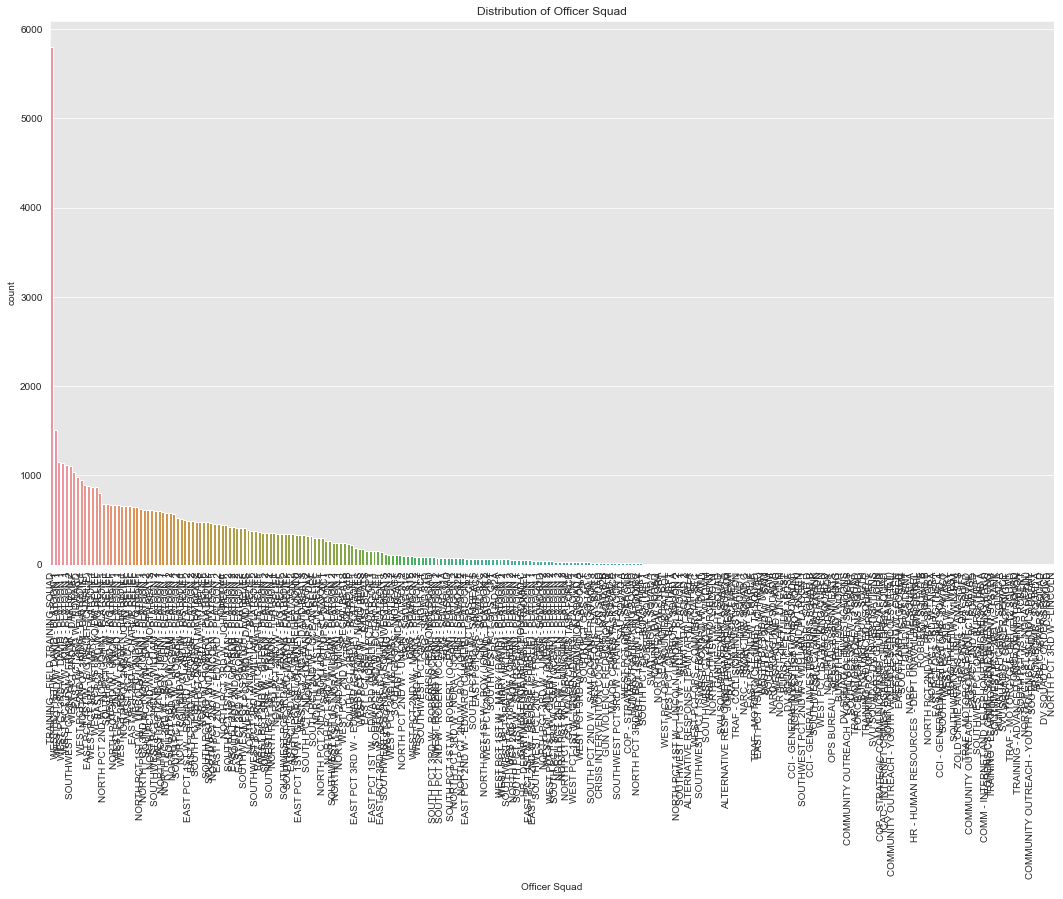

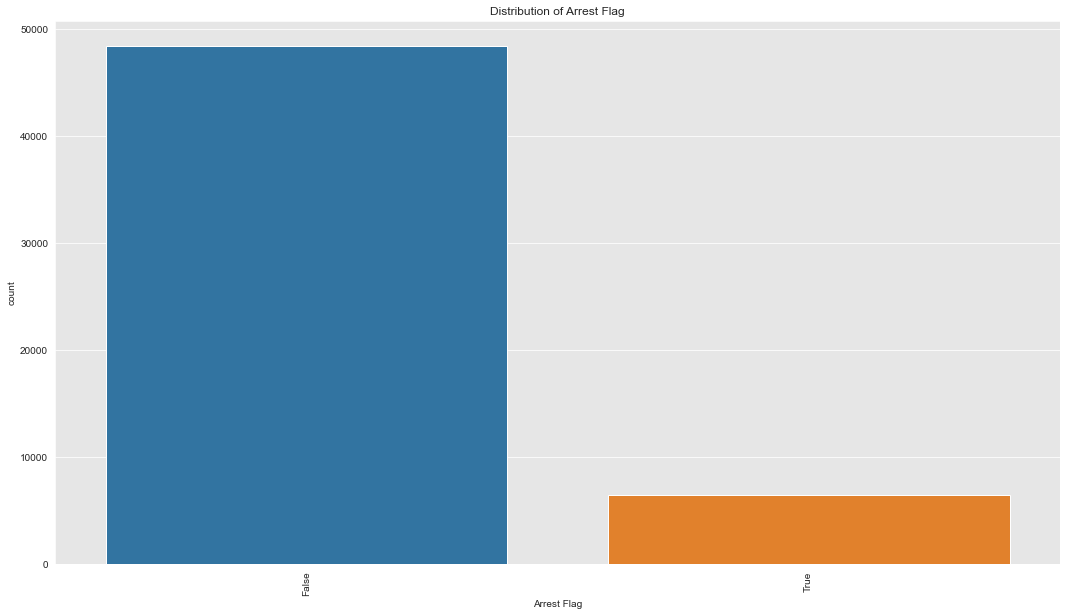

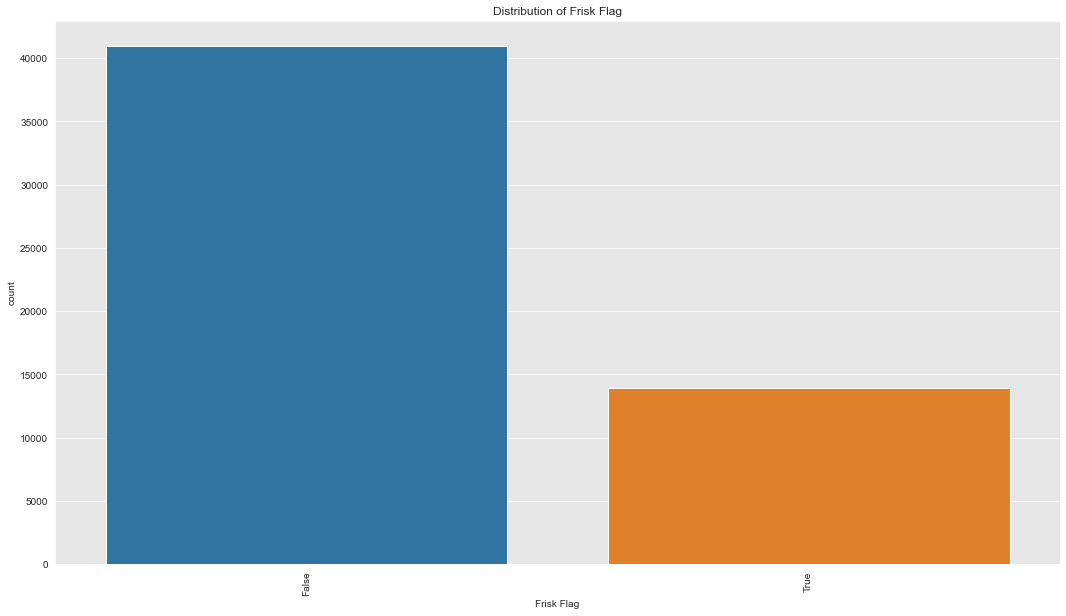

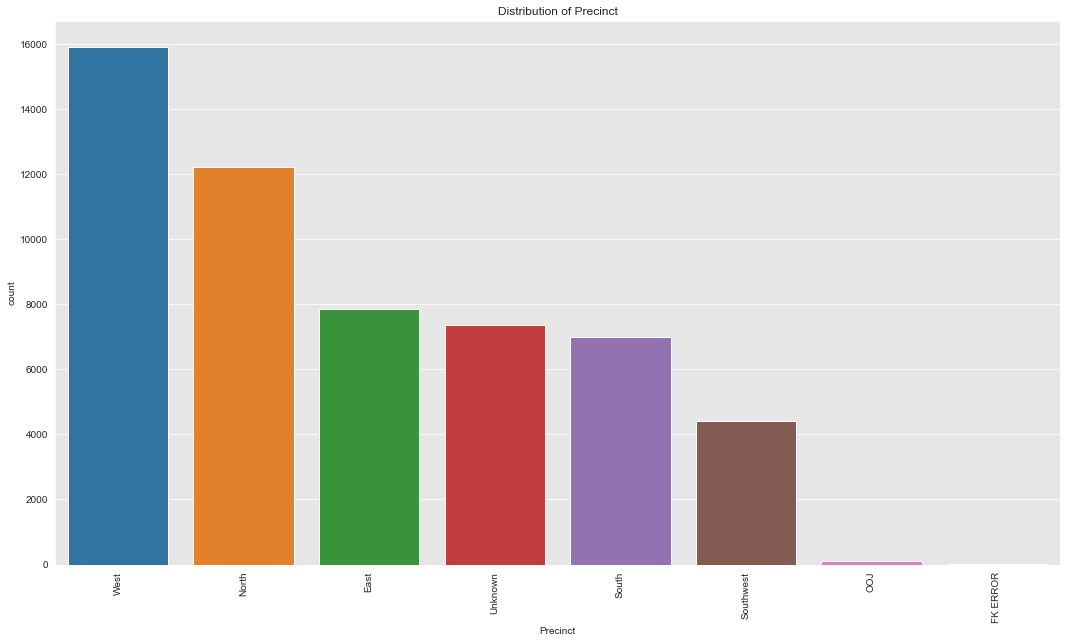

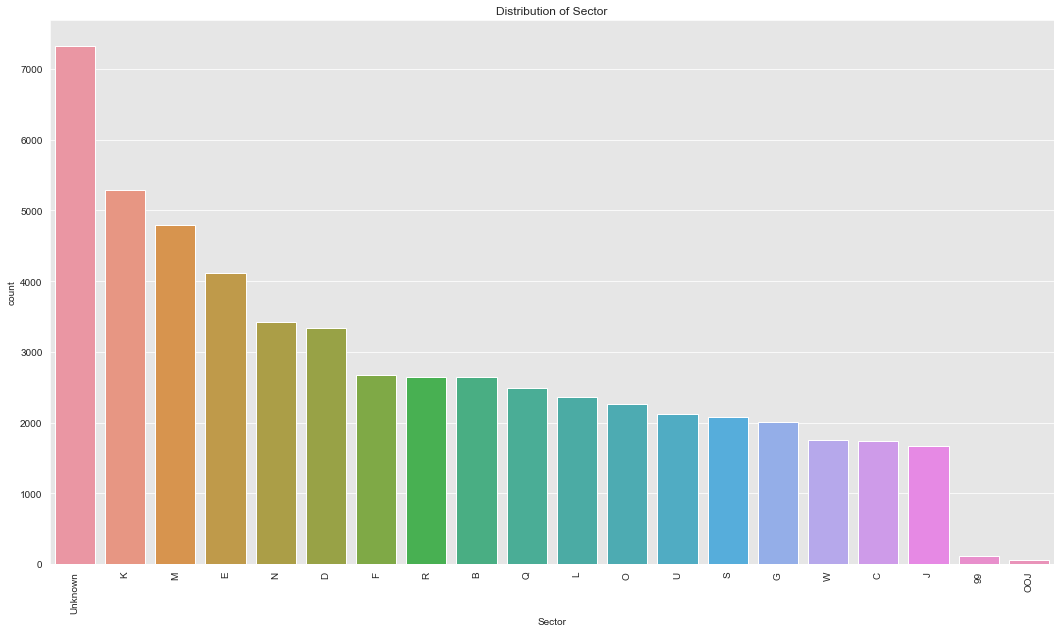

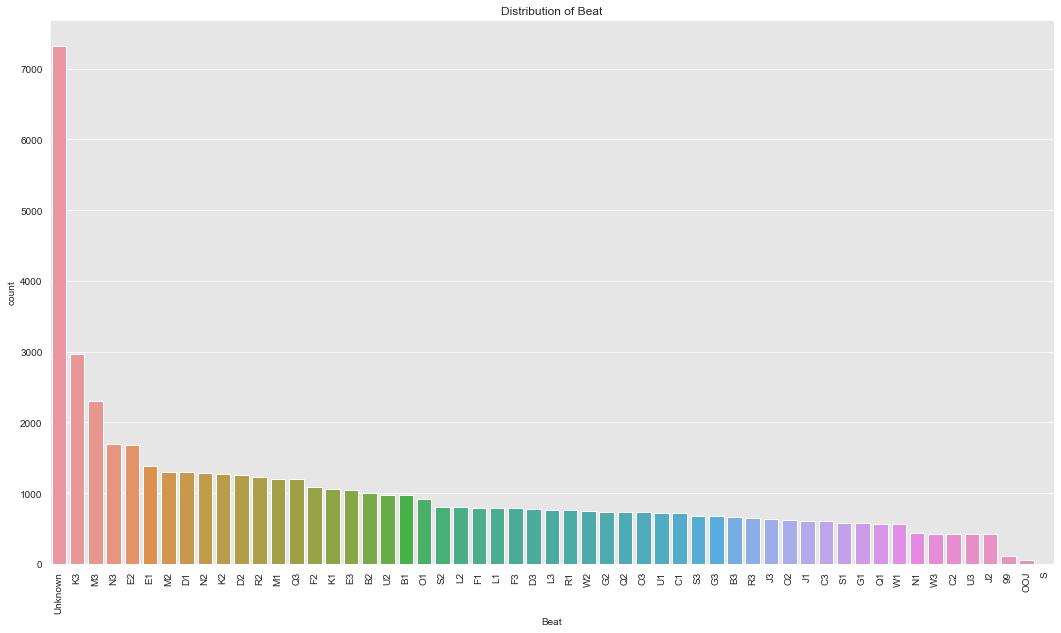

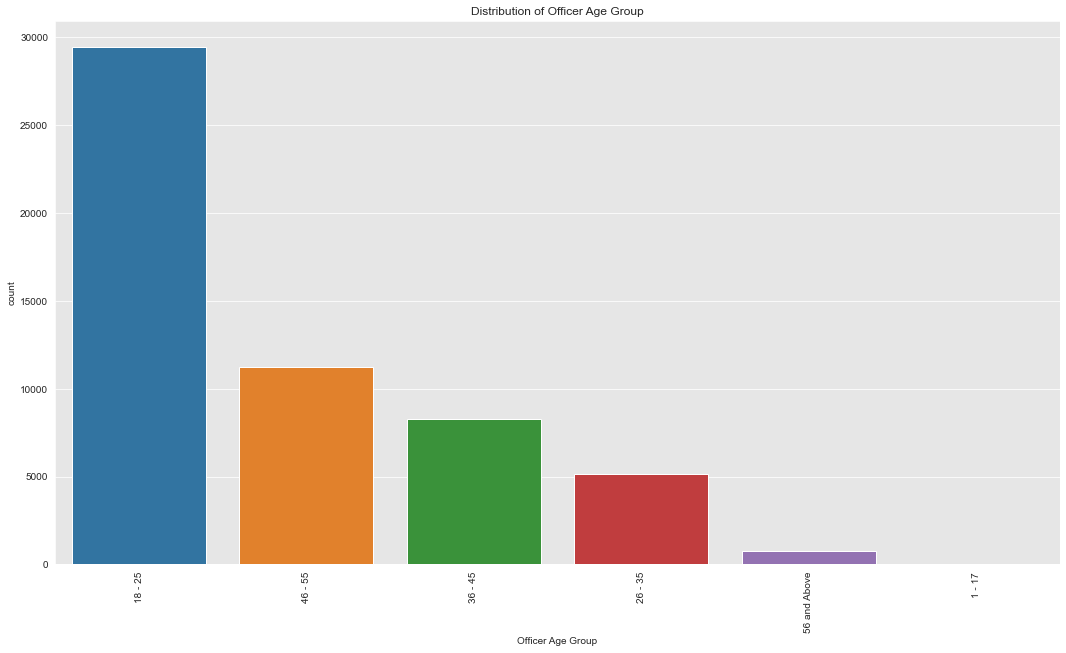

In [100]:
for column in df_preprocessed.columns:
    plt.figure(figsize = (18,10))
    sns.countplot(data=df_preprocessed, x=column, order=df_preprocessed[column].value_counts().index)
    plt.xticks(rotation=90)
    plt.title(f'Distribution of {df_preprocessed[column].name}')
    plt.show;

In [101]:
print('Summary of Frequency Distribution in our Features\n')
for column in X.columns:
    print(f'{column} has {X[column].nunique()} unique values')

Summary of Frequency Distribution in our Features

Subject Age Group has 6 unique values
Stop Resolution has 5 unique values
Weapon Type has 22 unique values
Officer Gender has 2 unique values
Officer Race has 8 unique values
Subject Perceived Race has 10 unique values
Subject Perceived Gender has 6 unique values
Initial Call Type has 180 unique values
Final Call Type has 196 unique values
Call Type has 7 unique values
Officer Squad has 271 unique values
Frisk Flag has 2 unique values
Precinct has 8 unique values
Sector has 20 unique values
Beat has 55 unique values
Officer Age Group has 5 unique values


Some of our features have high cardinality as exhibited by their high frequency:

#### High Cardinality Features

1. Initial Call Type: 180 unique values
2. Final Call Type: 196 unique values
3. Officer Squad: 271 unique values
4. Beat: 55 unique values
5. Weapon Type: 22 unique value
6. Sector: 20 unique values

These features could lead to a high dimensional feature space if we apply one hot encoding (OHE) directly to our entire feature set.


#### Low Cardinality Features
1. Subject Age Group: 6 unique values
2. Stop Resolution: 5 unique values
3. Officer Gender: 2 unique values
4. Officer Race: 8 unique values
5. Subject Perceived Race: 10 unique values
6. Subject Perceived Gender: 6 unique values
7. Call Type: 7 unique values
8. Frisk Flag: 2 unique values
9. Precinct: 8 unique values
10. Officer Age Group: 5 unique values



# 5. Data Preparation

We will start by splitting our data into a training and test set before proceeding to avoid any data leakage

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

#### Target Encoding
We will use target encoding to deal with our high cardinality features.

Target encoding replaces each category with the mean of the target variable for that category. This reduces the dimensionality by not increasing the number of features, which can help in preventing overfitting. Example: If a category is frequently associated with positive outcomes (e.g., arrests), the encoding will reflect that association. Target encoding should not alter the shape of our data

In [103]:
from category_encoders.target_encoder import TargetEncoder

high_cardinality_cols = ['Initial Call Type', 'Final Call Type', 'Call Type', 'Officer Squad', 'Beat', 'Weapon Type','Sector']

target_encoder = TargetEncoder(cols = high_cardinality_cols)

#fit the target encoder to the high cardinality features
target_encoder.fit(X_train[high_cardinality_cols], y_train)

#transform the high cardinality features
X_train_te = target_encoder.transform(X_train[high_cardinality_cols])
X_test_te = target_encoder.transform(X_test[high_cardinality_cols])

#assign the transform values into a dataframe
X_train_te_df = pd.DataFrame(X_train_te, columns=X_train[high_cardinality_cols].columns)
X_test_te_df = pd.DataFrame(X_test_te, columns=X_test[high_cardinality_cols].columns)

#drop the original low cardinality features from our train and test set
X_train = X_train.drop(columns=high_cardinality_cols)
X_test = X_test.drop(columns=high_cardinality_cols)

# reset index of Train and Test
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

#reset index of te df
X_train_te_df = X_train_te_df.reset_index(drop=True)
X_test_te_df = X_test_te_df.reset_index(drop=True)

#update train and test feature set with the encoded values
X_train = pd.concat([X_train, X_train_te_df], axis=1)
X_test = pd.concat([X_test, X_test_te_df], axis=1)



X_train.head()

,Subject Age Group,Stop Resolution,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Frisk Flag,Precinct,Officer Age Group,Initial Call Type,Final Call Type,Call Type,Officer Squad,Beat,Weapon Type,Sector
0,26 - 35,Arrest,True,White,Unknown,Male,True,South,36 - 45,0.204152,0.093189,0.159758,0.123333,0.162857,0.111489,0.136159
1,46 - 55,Field Contact,True,White,Black or African American,Male,False,North,18 - 25,0.020547,0.020547,0.020547,0.123333,0.090767,0.111489,0.083767
2,36 - 45,Arrest,True,White,White,Male,False,Unknown,18 - 25,0.084399,0.215190,0.126020,0.121591,0.044037,0.111489,0.044001
3,46 - 55,Offense Report,True,White,Black or African American,Male,False,North,26 - 35,0.129316,0.247191,0.126020,0.057554,0.100604,0.111489,0.088740
4,26 - 35,Arrest,True,White,White,Male,True,Unknown,18 - 25,0.231481,0.163708,0.159758,0.131849,0.044037,0.428571,0.044001


In [104]:
X_test.head()

,Subject Age Group,Stop Resolution,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Frisk Flag,Precinct,Officer Age Group,Initial Call Type,Final Call Type,Call Type,Officer Squad,Beat,Weapon Type,Sector
0,18 - 25,Field Contact,True,White,Black or African American,Male,False,Unknown,46 - 55,0.020547,0.020547,0.020547,0.155280,0.044037,0.111489,0.044001
1,36 - 45,Offense Report,True,White,White,Male,False,South,46 - 55,0.096286,0.058811,0.159758,0.074534,0.144695,0.111489,0.104300
2,26 - 35,Offense Report,True,White,Asian,Male,False,East,18 - 25,0.088028,0.041856,0.100016,0.147059,0.127072,0.111489,0.127551
3,26 - 35,Arrest,True,White,Black or African American,Male,False,West,46 - 55,0.059748,0.093969,0.100016,0.073772,0.130293,0.111489,0.140967
4,56 and Above,Arrest,True,White,Black or African American,Male,False,North,18 - 25,0.101770,0.201677,0.159758,0.025397,0.044118,0.111489,0.083767


We will do some checks on our data to make sure we have preserved the integrity of our data

In [105]:
print(X_train.index[:5])
print(X_train_te_df.index[:5])

RangeIndex(start=0, stop=5, step=1)
RangeIndex(start=0, stop=5, step=1)


In [106]:
print(X_test.index[:5])
print(X_test_te_df.index[:5])

RangeIndex(start=0, stop=5, step=1)
RangeIndex(start=0, stop=5, step=1)


In [107]:
X_train.isna().sum()

Subject Age Group           0
Stop Resolution             0
Officer Gender              0
Officer Race                0
Subject Perceived Race      0
Subject Perceived Gender    0
Frisk Flag                  0
Precinct                    0
Officer Age Group           0
Initial Call Type           0
Final Call Type             0
Call Type                   0
Officer Squad               0
Beat                        0
Weapon Type                 0
Sector                      0
dtype: int64

Let's compare the shape of our encoded data with the original data.

In [108]:
print('No. of rows in encoded data:', (X_train.shape[0]+X_test.shape[0]))
print('No. of rows in original data:', (df_preprocessed.shape[0]))
print(f'No of features in encoded data {X_train.shape[1]} in Train Set and {X_test.shape[1]} in test set:')
print('No. of features in original data:', (df_preprocessed.drop('Arrest Flag', axis=1).shape[1]))

No. of rows in encoded data: 54868
No. of rows in original data: 54868
No of features in encoded data 16 in Train Set and 16 in test set:
No. of features in original data: 16


As expected, target encoding does not change the shape of our data, we did not alter the shape of our data or create missing values

#### One Hot Encoding

Next, we will one hot encode our low cardinality features. Unlike with target encoding, one hot encoding will alter the shape of our data by creating additional columns for each unique value of our low cardinality features (and dropping the first column of each category since it does not add any new information that we cannot get by aggregating the rest of the columns for similar categories).

In [109]:
#select low cardinality features from our dataframe and drop the target
low_cardinality_cols = df_preprocessed.drop(columns = high_cardinality_cols +['Arrest Flag']).columns 

#fit the ohe
ohe = OneHotEncoder(handle_unknown="ignore")
ohe.fit(X_train[low_cardinality_cols])

#transform our train and test feature set
X_train_ohe = ohe.transform(X_train[low_cardinality_cols])
X_test_ohe = ohe.transform(X_test[low_cardinality_cols])   

#assign the transform values into a dataframe
X_train_ohe_df = pd.DataFrame(X_train_ohe.toarray(), columns=ohe.get_feature_names_out(X_train[low_cardinality_cols].columns))
X_test_ohe_df = pd.DataFrame(X_test_ohe.toarray(), columns=ohe.get_feature_names_out(X_test[low_cardinality_cols].columns))

#drop the original low cardinality features from our train and test set
X_train = X_train.drop(low_cardinality_cols, axis=1)
X_test = X_test.drop(low_cardinality_cols, axis=1)

# reset index of Train and Test
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

#reset index of ohe
X_train_ohe_df = X_train_ohe_df.reset_index(drop=True)
X_test_ohe_df = X_test_ohe_df.reset_index(drop=True)


#update train and test feature set with the encoded values
X_train = pd.concat([X_train, X_train_ohe_df], axis=1 )
X_test = pd.concat([X_test, X_test_ohe_df], axis=1)

X_train.head()

,Initial Call Type,Final Call Type,Call Type,Officer Squad,Beat,Weapon Type,Sector,Subject Age Group_1 - 17,Subject Age Group_18 - 25,Subject Age Group_26 - 35,...,Precinct_OOJ,Precinct_South,Precinct_Southwest,Precinct_Unknown,Precinct_West,Officer Age Group_18 - 25,Officer Age Group_26 - 35,Officer Age Group_36 - 45,Officer Age Group_46 - 55,Officer Age Group_56 and Above
0,0.204152,0.093189,0.159758,0.123333,0.162857,0.111489,0.136159,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.020547,0.020547,0.020547,0.123333,0.090767,0.111489,0.083767,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.084399,0.215190,0.126020,0.121591,0.044037,0.111489,0.044001,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.129316,0.247191,0.126020,0.057554,0.100604,0.111489,0.088740,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.231481,0.163708,0.159758,0.131849,0.044037,0.428571,0.044001,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [110]:
X_test.head()

,Initial Call Type,Final Call Type,Call Type,Officer Squad,Beat,Weapon Type,Sector,Subject Age Group_1 - 17,Subject Age Group_18 - 25,Subject Age Group_26 - 35,...,Precinct_OOJ,Precinct_South,Precinct_Southwest,Precinct_Unknown,Precinct_West,Officer Age Group_18 - 25,Officer Age Group_26 - 35,Officer Age Group_36 - 45,Officer Age Group_46 - 55,Officer Age Group_56 and Above
0,0.020547,0.020547,0.020547,0.155280,0.044037,0.111489,0.044001,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.096286,0.058811,0.159758,0.074534,0.144695,0.111489,0.104300,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.088028,0.041856,0.100016,0.147059,0.127072,0.111489,0.127551,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.059748,0.093969,0.100016,0.073772,0.130293,0.111489,0.140967,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.101770,0.201677,0.159758,0.025397,0.044118,0.111489,0.083767,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


As above, we will do some checks on our data to make sure we have preserved the integrity of our data

In [111]:
X_train.isna().sum()

Initial Call Type                                                                     0
Final Call Type                                                                       0
Call Type                                                                             0
Officer Squad                                                                         0
Beat                                                                                  0
Weapon Type                                                                           0
Sector                                                                                0
Subject Age Group_1 - 17                                                              0
Subject Age Group_18 - 25                                                             0
Subject Age Group_26 - 35                                                             0
Subject Age Group_36 - 45                                                             0
Subject Age Group_46 - 55       

In [112]:
print(X_train.index[:5])
print(X_train_ohe_df.index[:5])

RangeIndex(start=0, stop=5, step=1)
RangeIndex(start=0, stop=5, step=1)


In [113]:
print(X_test.index[:5])
print(X_test_ohe_df.index[:5])

RangeIndex(start=0, stop=5, step=1)
RangeIndex(start=0, stop=5, step=1)


In [114]:
print('No. of rows in encoded data:', (X_train.shape[0]+X_test.shape[0]))
print('No. of rows in original data:', (df_preprocessed.shape[0]))
print(f'No of features in encoded data {X_train.shape[1]} in Train Set and {X_test.shape[1]} in test set:')
print('No. of features in original data:', (df_preprocessed.drop('Arrest Flag', axis=1).shape[1]))

No. of rows in encoded data: 54868
No. of rows in original data: 54868
No of features in encoded data 57 in Train Set and 57 in test set:
No. of features in original data: 16


As expected, our rows are preserved but our encoded data now has additional columns

# 6. Modeling

### Baseline Metrics

We will create a baseline model that always predicts the positive class. We will use the model's score to evaluate our logistic models.


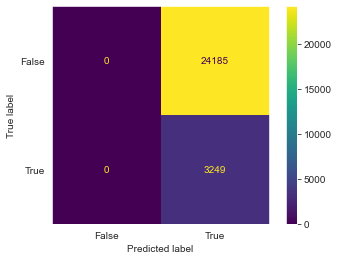

In [115]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.dummy import DummyClassifier

ConfusionMatrixDisplay.from_estimator(estimator=DummyClassifier(strategy='constant', constant=1).fit(X_train, y_train),
                                       X=X_test, y=y_test)


plt.grid(False);

In [116]:
# Fit the DummyClassifier (baseline model)
dummy_clf = DummyClassifier(strategy='constant', constant=1)
dummy_clf.fit(X_train, y_train)

# Predict using the baseline model on the test set
y_pred_baseline = dummy_clf.predict(X_test)

# Calculate accuracy score
accuracy_baseline = accuracy_score(y_test, y_pred_baseline)
print(f"Baseline Model Accuracy: {accuracy_baseline:.4f}")

# Generate the classification report
print("\nBaseline Model Classification Report:")
print(classification_report(y_test, y_pred_baseline, zero_division=0, target_names=['False', 'True']));


Baseline Model Accuracy: 0.1184

Baseline Model Classification Report:
              precision    recall  f1-score   support

       False       0.00      0.00      0.00     24185
        True       0.12      1.00      0.21      3249

    accuracy                           0.12     27434
   macro avg       0.06      0.50      0.11     27434
weighted avg       0.01      0.12      0.03     27434



**Baseline Model Results**

**Baseline Model Accuracy: 0.1184:**\
This indicates that the baseline model, which always predicts the positive class (Arrest), has an accuracy of about 11.84%. This is expected since the positive class makes up only a small fraction of the total cases in the dataset.

**Classification Report:**

**False Class (No Arrest):** \
The model's precision, recall, and F1-score are all 0.00 because it never predicts the negative class (No Arrest). Hence, the precision and F1-score are undefined (zero)

**True Class (Arrest):**
- Precision: 0.12 — This is low because the model predicts the positive class (Arrest) regardless of the actual outcome, which means it gets all the negatives wrong.
- Recall: 1.00 — This is perfect because, by always predicting the positive class, the model captures all actual positive instances.
- F1-Score: 0.21 — This is the harmonic mean of precision and recall, and it's low due to the very poor precision.


### Logistic Regression

We will start by training our model by fitting the training data to a logistic regression model. 

**1.  Model 1**

- ***C***: This parameter controls the regularization strength. A higher C reduces the penalty on the model for large coefficients allowing to fit the data more optimally but with additional risk of overfitting.
- ***solver***: This parameter specifies the algorithm used to optimize the model. 'lbfgs' is a limited-memory solver that can be efficient for large datasets.
- ***random_state***: This parameter sets the random seed for the model, ensuring reproducibility.
- ***max_iter***: This parameter sets the maximum number of iterations for the solver.

In [117]:
# train a logistic regression model on the training set
from sklearn.linear_model import LogisticRegression


# instantiate the model
logreg = LogisticRegression(C = 100, solver='lbfgs', random_state=0, max_iter=1000)


# fit the model
logreg.fit(X_train, y_train)


LogisticRegression(C=100, max_iter=1000, random_state=0)

Next, we apply the model to our test set to see its predictive performance

In [129]:
y_pred_test = logreg.predict(X_test)

y_pred_test

array([False, False, False, ..., False, False, False])

Let us to see the no. of unique values in our target again before assessing the perfomance of our model.

In [130]:
true_proportion = y_test.value_counts(normalize=True)[1] 


false_proportion = y_test.value_counts(normalize=True)[0]
print(f"True: {true_proportion:.2f}") 
print(f"False: {false_proportion:.2f}")

True: 0.12
False: 0.88


The data summary shows that the 'Arrest Flag' is imbalanced, with the 'False' class (no arrest) comprising 88% and the 'True' class (arrest) only 12% of the dataset. This means that most stops do not result in an arrest.

In [120]:
from sklearn.metrics import accuracy_score, classification_report

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred_test)))
print(classification_report(y_test,y_pred_test))

Model accuracy score: 0.9213
              precision    recall  f1-score   support

       False       0.95      0.96      0.96     24185
        True       0.69      0.61      0.65      3249

    accuracy                           0.92     27434
   macro avg       0.82      0.79      0.80     27434
weighted avg       0.92      0.92      0.92     27434



In [121]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(logreg.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(logreg.score(X_test, y_test)))

Training set score: 0.9267
Test set score: 0.9213


In [122]:
from sklearn.metrics import roc_curve, auc

# First calculate the probability scores of each of the datapoints:
y_score = logreg.fit(X_train, y_train).decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)

AUC: 0.965091830548774


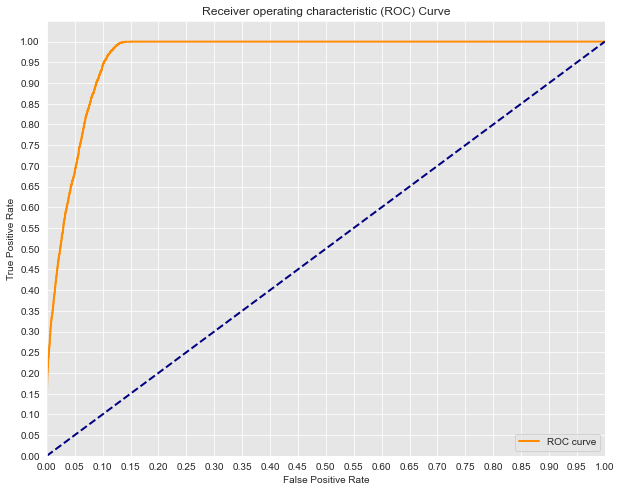

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

#### **Model 1 Analysis** ####

**Model 1 Performance**:

****a. Overall Model Accuracy:****\
Our training set score of 92.1% and test set score of 92.7% imply that our model is highly accurate. The minimal difference between the test and training scores suggest our model generalizies well ie. not overfitting or undefitting.


****b. Classification Report:****\
Precision and Recall for the False Class: 
- Precision: 0.95
- Recall: 0.96
- F1-Score: 0.96

These scores indicate the model performs very well in predicting the majority class (False).

Precision and Recall for the True Class:
- Precision: 0.69
- Recall: 0.61
 - F1-Score: 0.65
 
This shows the model struggles to accurately predict the minority class (True), missing 39% of the actual positives.

****c. ROC Curve:****\
The ROC curve shows a high True Positive Rate (TPR) or Sensitivity against a low False Positive Rate (FPR) across the threshold range, indicating strong performance in distinguishing between the classes.The curve is close to the top-left corner, which represents excellent performance.


**Comparison vs Baseline Model:**

Our model shows general improvement from our baseline model.

**Accuracy:**\
The logistic regression model's accuracy (92.13%) is significantly higher than the baseline (11.84%), indicating our logistic regression model performs much better at correctly classifying instances overall.

**Precision:**\
For the baseline model, precision is 0 for the False class, as it never predicts False. For the True class, precision is 0.12, which is very low and reflects a high number of False Positives.
Precision is notably higher in our logistic regression, especially for the True class (0.69), suggesting that when the logistic regression predicts True, it is correct about 69% of the time, which is a substantial improvement.

**Recall:**\
The baseline model has perfect recall (1.00) for the True class because it predicts True for all cases, but it misses all False cases (recall = 0 for False).
The logistic regression has balanced recall between False (0.96) and True (0.61), showing it is capable of detecting both classes, albeit less so for True cases due to class imbalance.

**F1 Score:**\
The F1-score is low overall in our baseline model, with the False class scoring 0 and the True class at 0.21, reflecting poor precision and recall balance.
In comparison, in our logistic regression mode, the F1-score for both classes is significantly improved (False: 0.96, True: 0.65), indicating a better balance between precision and recall.



****Implications of Class Imbalance:****
- Biased Model Predictions: Class imbalance can cause our logistic regression model to be biased towards predicting the majority class ('False' for no arrest) because predicting the majority class more frequently would still yield a high accuracy. In law enforcement, accurately predicting the 'Arrest Flag' is crucial. Misclassifying an actual arrest situation (False Negative) could have serious implications, such as failing to appropriately flag an encounter where an arrest should have occured.

- Underperformance on Minority Class: As seen in the classification report, the precision and recall for the 'True' class (arrest) are significantly lower than for the 'False' class. This suggests that the model struggles to correctly identify and predict arrests, which is the minority class. Overpredicting 'False' (no arrest) could lead to missed opportunities for police intervention, which might not align with the goals of public safety and proper law enforcement.


****Using SMOTE to Address Class Imbalance****

SMOTE (Synthetic Minority Oversampling) generates new sample data using 'synthetic' data from our original dataset, this reduces class imbalance by increasing the number of minority class instances in our dataset. 



Original class distribution: 

False    24179
True      3255
Name: Arrest Flag, dtype: int64
-----------------------------------------
True     24179
False    24179
Name: Arrest Flag, dtype: int64
AUC for 0.25: 0.9646924646523765
-------------------------------------------------------------------------------------
AUC for 0.5: 0.9645550963248627
-------------------------------------------------------------------------------------
AUC for 0.75: 0.9643067159609486
-------------------------------------------------------------------------------------
AUC for 1.0: 0.9641048504420467
-------------------------------------------------------------------------------------


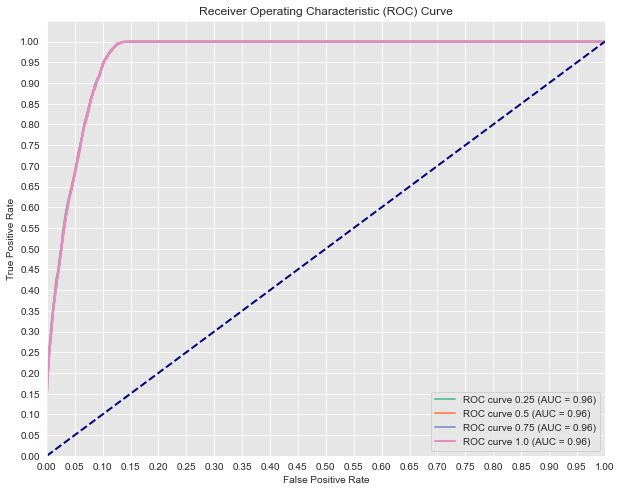

In [131]:
from imblearn.over_sampling import SMOTE

print('Original class distribution: \n')
print(y_train.value_counts())

# Initialize SMOTE and resample the data
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Preview synthetic sample class distribution
print('-----------------------------------------')
print(pd.Series(y_train_resampled).value_counts())

# Now let's compare a few different ratios of minority class to majority class
ratios = [0.25, 0.5, 0.75, 1.0]
names = ['0.25', '0.5', '0.75', '1.0'] 


plt.figure(figsize=(10, 8))

for n, ratio in enumerate(ratios):
    # Fit a model using different SMOTE ratios
    smote = SMOTE(sampling_strategy=ratio)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    logreg = LogisticRegression(fit_intercept=False, C=100, solver='lbfgs', max_iter = 100_000)
    model_log = logreg.fit(X_train_resampled, y_train_resampled)

    # Predict on the test set
    y_hat_test = logreg.predict(X_test)
    y_score = logreg.decision_function(X_test)

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    auc_score = auc(fpr, tpr)

    # Print the AUC for the current ratio
    print(f'AUC for {names[n]}: {auc_score}')
    print('-------------------------------------------------------------------------------------')

    # Plot the ROC curve
    lw = 2
    plt.plot(fpr, tpr, color=colors[n], lw=lw, label=f'ROC curve {names[n]} (AUC = {auc_score:.2f})')

# Plot settings
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


Let us also generate a classification report to our model performance

In [125]:
# Fit a model using the highest SMOTE ratio
smote = SMOTE(sampling_strategy=1.0)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
logreg = LogisticRegression(fit_intercept=False, C=100, solver='lbfgs', max_iter = 100_000)
model_log = logreg.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_hat_test = logreg.predict(X_test)
y_score = logreg.decision_function(X_test)

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_hat_test)))
print(classification_report(y_test,y_hat_test))

Model accuracy score: 0.8970
              precision    recall  f1-score   support

       False       1.00      0.89      0.94     24185
        True       0.54      0.98      0.69      3249

    accuracy                           0.90     27434
   macro avg       0.77      0.93      0.81     27434
weighted avg       0.94      0.90      0.91     27434



#### **Model 2 Analysis** ####

****Before SMOTE:****
 - Accuracy: 0.9213
 - Precision (True): 0.69
 - Recall (True): 0.61
 - F1-score (True): 0.65

****After SMOTE:****
 - Accuracy: 0.8966
 - Precision (True): 0.53
 - Recall (True): 0.97
 - F1-score (True): 0.69

While our model's recall has improved greatly, meaning we are able to predict true postives(actual arrests) significantly better based on an improvement from 0.61 to 0.97, our precision has suffered as is evident from the drop from 0.69 to 0.53. Our overall model accuracy has also dropped from 0.9213 to 0.8973.
Let's try a different SMOTE ratio to see if we can limit the impact on precision i.e. reduce the amount of false positives (or incorrectly predicted arrests).

In [126]:
# fir a model using the lowest SMOTE ratio
smote = SMOTE(sampling_strategy=0.25)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
logreg = LogisticRegression(fit_intercept=False, C=100, solver='lbfgs', max_iter = 100_000)
model_log = logreg.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_hat_test = logreg.predict(X_test)
y_score = logreg.decision_function(X_test)

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_hat_test)))
print(classification_report(y_test,y_hat_test))

Model accuracy score: 0.9166
              precision    recall  f1-score   support

       False       0.97      0.93      0.95     24185
        True       0.61      0.81      0.70      3249

    accuracy                           0.92     27434
   macro avg       0.79      0.87      0.82     27434
weighted avg       0.93      0.92      0.92     27434



#### **Model 3 Analysis** ####

****Before SMOTE:****
 - Accuracy: 0.9213
 - Precision (True): 0.69
 - Recall (True): 0.61
 - F1-score (True): 0.65

****After SMOTE:****
 - Accuracy: 0.9167
 - Precision (True): 0.61
 - Recall (True): 0.81
 - F1-score (True): 0.70



****Key Observations:****

**a. Recall for predicting arrests improved significantly from 0.61 to 0.81.**\
This means the model is now much better at identifying true positives (actual arrests), which is crucial in scenarios where failing to predict an arrest correctly might have serious consequences.

**b. Precision for the minority class dropped from 0.69 to 0.61 after SMOTE.**\
This decrease implies that the model now has more false positives, i.e., it incorrectly predicts arrests more frequently. However, the decline is not material and this is a trade off we are willing to make given the improvements in predicting actual arrests.

**c. The F1-score for predicting arrests increased from 0.65 to 0.70.**\
This balanced metric of precision and recall suggests an overall improvement in predicting the minority class

**d. The overall accuracy slightly decreased from 0.9213 to 0.9167**\
This is a minor reduction and is  acceptable given the other improvements in model performance.

### Most Important Features

We will get derive the most important features in our model based on their coefficients in our model

In [127]:
feature_names = X_train.columns

coefficients = logreg.coef_[0] 

#add feature names and coefficients to a dataframe
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort features by absolute value of the coefficient
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

print(coef_df[['Feature', 'Coefficient']])


                                              Feature  Coefficient
5                                         Weapon Type    26.287668
3                                       Officer Squad    13.871596
4                                                Beat    13.389792
6                                              Sector   -10.743975
15                      Stop Resolution_Field Contact   -10.291750
13                             Stop Resolution_Arrest     9.185109
33  Subject Perceived Race_Native Hawaiian or Othe...     7.833878
31                    Subject Perceived Race_Hispanic    -7.601820
40       Subject Perceived Gender_Unable to Determine    -7.242715
16                     Stop Resolution_Offense Report    -7.133663
32                Subject Perceived Race_Multi-Racial    -6.583463
34                       Subject Perceived Race_Other    -5.666279
19                                Officer Gender_True    -4.415634
43                                    Frisk Flag_True    -4.34

# 7. Conclusion

### **a. Major Objective: Derive the most important features in predicting an arrest:**

Our most important features are the following:

**1. Stop Resolution_Field Contact (coefficient: -11.1)** - this is a feature that arose because of one hot encoding our data but signals that most stops arising naturally in the field end up with no arrests as signalled by the negative coefficient.

**2. Beat (Coefficient: 12.40)**- The Beat feature has a significant positive coefficient, indicating that certain beats are more associated with arrests. This could be related to specific crime rates, community issues, or patrol patterns in those beats.

**3. Officer Squad (coefficient: 13.81)** - The positive coefficient for Officer Squad indicates that the specific squad or team involved in the stop is a significant factor in predicting arrests. This may reflect differences in squad practices, experience, or operational focus.

**4. Weapon Type (Coefficient: 26.14)** -The high positive coefficient for Weapon Type suggests that the presence of a weapon is a strong predictor of an arrest. This is intuitive, as encounters involving weapons are more likely to escalate to an arrest due to safety concerns and legal considerations.

**5. Sector (Coefficient: -10.90)** - The negative coefficient for Sector suggests that certain sectors are less likely to result in an arrest. This could be due to differences in crime patterns or the nature of incidents in different sectors.

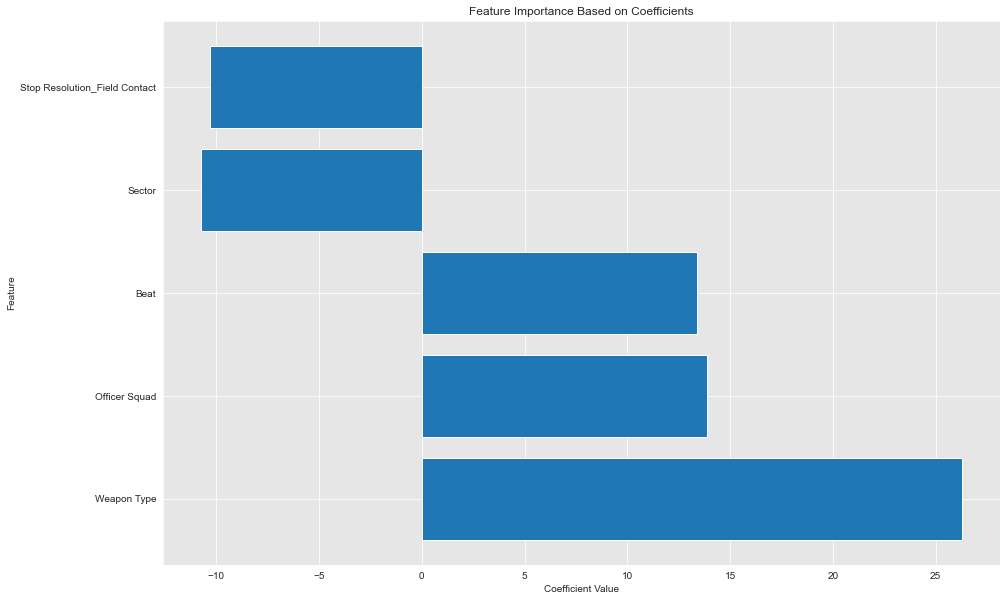

In [128]:
plt.figure(figsize=(15, 10))
plt.barh(coef_df['Feature'][:5], coef_df['Coefficient'][:5])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance Based on Coefficients')
plt.show()

### **b. Develop a Predictive Model for Arrests During Terry Stops**

Our final model gernerally improves upon the baseline model and earlier iterations.

**Accuracy Score: 91.67%**. This indicates that the model performs well overall.

**Precision and Recall:**

- Precision for False (No Arrest): 0.97
- Recall for False (No Arrest): 0.93
- Precision for True (Arrest): 0.61
- Recall for True (Arrest): 0.81

While the model has a high accuracy, this is mostly due to predicting situations where no arrest is made as signified by the high precision and recall for the False class. Its performance on predicting arrests (the minority class) reveals a trade-off: higher recall but lower precision. This means the model is good at identifying cases where an arrest is likely but might also incorrectly label some non-arrest cases as arrests. While we tried to reduce this trade-off, given the nature of the data, we cannot resolve it fully. This is an important consideration in the practical use of the model for future prediction.

### **c. EDA and Feature Engineering:**

Our exploratory data analysis (EDA) highlighted some issues with missing values where some rows had blank values and others had been filled in with a placeholder value ('-').

**Handling of missing values:**

1. Subject Age Group  - we imputed this with mode to preserve the shape of our data.

2. Weapon Type - Imputed with 'None" given that a since several rows were blank, it’s possible that in many cases, no weapon was found.

3. Officer ID - Since only 24 out of 60,962 entries are affected, we dropped these rows.

4. Subject Perceived Race - We replaced missing values with "Unknown" to maintain the data structure without introducing bias.

5. Subject Perceived Gender - We replaced missing values with "Unknown" to maintain the data structure without introducing bias..

6. Initial Call Type, Final Call Type, Call Type - We imputed this with "Unknown" since missing call types might suggest a lack of information or a specific condition (e.g., not applicable since no call was made and the incident just transpired).

7. Frisk Flag - We imputed missing values with the mode since the missing values are minimal.

8. Precint, Sector, Beat - We filled missing values with "Unknown" allowing us to retain the rows.

9. Officer Squad - imputed with "Unknown" to retain the rows

**Enchoding Techniques**

We used 'Target Encoding' to replace each feature that exhibited high cardinality with the mean of the target variable for that category. This reduced the dimensionality by not increasing the number of features, which can help in preventing overfitting. One hot encoding would not have been suitable for such features as they would have increased the number of features in our dataset by a significant magnitude.

We used 'One Hot Encoding' for features in our dataset with low cardinality  One-hot encoding transforms categorical variables into a format that can be easily interpreted by our logistic regression model. Each category is represented by a binary feature (0 or 1), preserving the information contained in the categorical features.  


### **d. Class Imbalance Management:**

We used SMOTE to address the class imbalance in our target variable.

Addressing class imbalance using SMOTE (Synthetic Minority Over-sampling Technique) was important in our logistic regression modeling process due to the following reasons:

**1. Improvement in Minority Class Recall:**\
In the initial logistic regression model without addressing class imbalance, the recall for the True class (minority class) was relatively low (0.61), meaning that a significant portion of the actual True cases were being missed.
After applying SMOTE, the recall for the True class improved significantly (0.81), indicating that the model became much better at detecting the minority class instances (i.e., Arrests), which is a critical goal in our main objective

**2. Balanced Performance Across Classes:**\
Without addressing the imbalance, the logistic regression model performed extremely well on the majority class (False) but poorly on the minority class (True). This imbalance in performance was reflected in the F1-score and recall differences. Applying SMOTE balanced the dataset, allowing the logistic regression model to learn equally well from both classes. As a result, the F1-score for the True class improved, leading to a more balanced performance that reflects a model capable of handling both True and False outcomes more equitably.

**3. Mitigation of Bias Towards Majority Class:**\
Imbalanced datasets cause models to be biased towards predicting the majority class e.g., the baseline model's constant prediction of the majority class (No Arrests) resulted in low precision and F1-scores. SMOTE helped mitigate this bias by synthetically oversampling the minority class, providing the model with a more representative training set. This change encouraged our model to learn the features distinguishing Arrests and No Arrests more effectively resulting in the models overall predictive ability given identifying minority class instances (arrests) is crucial, as false negatives (missed True cases) can have significant real-world implications.**

# 7. Recommendations

**1. Enhance Training and Protocols for Weapon-Related Stops**

Given the strong positive correlation between the presence of a weapon (Weapon Type) and the likelihood of an arrest, SPD should emphasize comprehensive training for officers on handling stops involving weapons. This training can include creating specific modules addressing the handling of weapon-related encounters including simulations and scenario-based derived from the predictions of the model to prepare officers for real-world situations.

Additionally, SPD should continuously monitor the outcomes of weapon-related stops  comparing them to the outcomes predicted by the model.

**2. Evaluate and Optimize Squad Practices**

SPD should analyze practices across different squads to identify successful strategies and areas for improvement. This can be done in the following ways:

 - Conduct Performance Reviews: Analyze arrest data and performance metrics for each squad to identify best practices and discrepancies in arrest rates.
 - Share Best Practices: Develop a best practices guide based on high-performing squads and distribute it across the department.
 - Targeted Training: Provide additional training or support to squads with lower arrest rates to align their practices with successful strategies observed in other squads.

**3. Adjust Resource Allocation Based on Beats and Sectors**

The analysis of Beat and Sector features indicates varying likelihoods of arrests across different areas. SPD should adjust resource allocation and patrol strategies based on these insights to optimize effectiveness. This can be done in the following ways

 - Resource Reallocation: Adjust patrol patterns and allocate resources based on crime rates and arrest patterns observed in different beats and sectors.
 - Community Engagement: Increase community policing efforts in beats and sectors with higher arrest rates to build relationships and address underlying issues that may contribute to higher arrest rates.
 - Sector-Specific Strategies: Develop targeted strategies for sectors with lower arrest rates to understand if there are specific challenges or factors affecting law enforcement outcomes.

**4. Review and Standardize Field Contact Procedures**

The negative coefficient for Stop Resolution_Field Contact suggests that stops resulting in field contacts are less likely to lead to arrests. SPD should continue to review the outcomes of actual stops to those predicted by the model to ensure that field contacts are well-justified and in line with department policies.

**5. Use Model to Improve Law Enforcement Practices**

 - Implement Decision-Making Frameworks: Use the model as one tool among many in decision-making processes. Combine model predictions with officer judgment and contextual information to make balanced decisions.
 - Continuous Model Improvement: Regularly update and refine the model to improve performance on predicting arrests. Consider exploring other advanced techniques for class imbalance management, such as different sampling methods.
 - Evaluation and Feedback: Continuously evaluate the impact of the predictive model on real-world outcomes and gather feedback from officers to make necessary adjustments and improvements.
